---
title: "Exploratory Data Analysis"
format:
    html: 
        toc: true
        code-fold: true
        embedded-resouces: true
bibliography: ../../references.bib
---

# Introduction and Motivation  
The goal of this EDA is to gain a deeper understanding of the dataset, identify key patterns, and uncover insights that will guide the next stages of the project. This analysis focuses on exploring the **geographic** and **demographic** distributions within the data, examining relationships between key variables, and preparing the dataset for modeling. By summarizing and visualizing the data, this section ensures that both the exonerated and non-exonerated groups are well-understood and balanced for supervised learning tasks.  


# Geographic Analysis

### Libraries and Tools  
To conduct the geospatial analysis, the following libraries were essential:  

- **Fiona**: For reading and writing GIS vector files.  
- **Shapely.geometry**: To create and manipulate geometric objects, such as points for latitude/longitude coordinates.  
- **GeoPandas**: An extension of pandas that integrates geographic data, allowing spatial operations like mapping and merging shapefiles.  
- **Matplotlib**: For creating static plots and visualizations.  

These tools provided the functionality to load, preprocess, and visualize geographic data effectively.

### Urban vs. Rural Classification  
Although the dataset does not explicitly label counties as urban or rural, external classification data from the [Illinois Primary Health Care Association (IPHCA)](https://dph.illinois.gov/content/dam/soi/en/web/idph/files/rur-urb-2021.pdf){target=_blank} was incorporated to provide important context for analyzing patterns in arrests, exonerations, and over-policing across Illinois counties. For further details, refer to **Appendix A**. [@iphca2020rural]  


In [341]:
# Import necessary Libraries
import pandas as pd
import seaborn as sns
import numpy as np 
import geopandas as gpd  # Extension of pandas used for working with geospatial data
import fiona  # Used for reading and writing GIS vector files
import matplotlib.pyplot as plt  # Used for creating static plots and visualizations
from shapely.geometry import Point  # Used for creating and analyzing geometric objects.

# Load cleaned exoneration dataset
exon_df = pd.read_csv('../../data/processed-data/illinois_exoneration_data.csv')
#exon_df.head()

## Geospatial Workflow
The following analyses involved a sequence of steps to prepare and visualize the exoneration and arrest data:  

### Geometry Creation
Using `shapely.geometry`, latitude and longitude values were converted into geometric points to map exoneration cases spatially. This allowed for the dataset to be transformed into a GeoDataFrame using **GeoPandas**.  


In [342]:
# Create geometry column for points based on latitude and longitude
geometry = [Point(xy) for xy in zip(exon_df['longitude'], exon_df['latitude'])]
geo_df = gpd.GeoDataFrame(exon_df, geometry=geometry)

### Loading Shapefiles
 The Illinois county boundary shapefile was loaded using **GeoPandas** (`gpd.read_file`). This file provided the geographic outlines needed to visualize data at the county level.  

In [343]:
# Load Illinois county shapefile 
illinois_counties = gpd.read_file('../../data/geospatial/IL_BNDY_COUNTY_Py.shp')

### Aggregating Exoneration Data 
Exoneration counts were grouped by county and race to produce a summarized table of exonerations (`groupby` in pandas). This data was then merged with the Illinois shapefile to align geographic boundaries with exoneration counts.  

In [344]:
# Aggregate exoneration counts by county and race
exoneration_counts = exon_df.groupby(['county', 'race'], as_index=False).size()
exoneration_counts.rename(columns={'size': 'num_exonerations'}, inplace=True)

illinois_counties['county'] = illinois_counties['COUNTY_NAM'].str.title()  # Match casing

# Merge exoneration data with shapefile
merged_counties = illinois_counties.merge(exoneration_counts, on='county', how='left')


### Aggregating Arrest Data 
Arrest counts were grouped by county and race to produce a summarized table of arrests (`groupby` in pandas). This data was then merged with the Illinois shapefile to align geographic boundaries with arrest totals.  

In [345]:
# Load aggregated arrests data
aggregated_data = pd.read_csv('../../data/processed-data/aggregated_arrests_2001_to_2021.csv')
aggregated_data_melted = aggregated_data.melt(id_vars='race', var_name='county', value_name='total_arrests')

# Aggregate total arrests by county for all races
total_arrests_by_county = aggregated_data_melted.groupby('county')['total_arrests'].sum().reset_index()

# Ensure county names are consistent
total_arrests_by_county['county'] = total_arrests_by_county['county'].str.strip().str.title()

# Merge total arrests data with the shapefile
merged_total_arrests = illinois_counties.merge(total_arrests_by_county, on='county', how='left')

### Handling Missing Data
Counties without recorded exonerations or arrests were assigned a count of `0` to ensure completeness in the visualizations.  


In [346]:
# Replace NaN values with 0 for counties without exonerations
merged_counties['num_exonerations'] = merged_counties['num_exonerations'].fillna(0)

# Fill NaN values with 0 for counties without data
merged_total_arrests['total_arrests'] = merged_total_arrests['total_arrests'].fillna(0)


### Logarithmic Transformation
The geospatial analysis visualizes exoneration and arrest patterns across Illinois counties. Cook County’s numbers are **orders of magnitude higher** than those in other counties, which skews the results and makes it difficult to identify trends in smaller counties on a linear scale. To address this, two scaling approaches were used:  

-  **Logarithmic Scaling (Including Cook County)**: Log transformations (`np.log1p`) compress the data range, making patterns in smaller counties clearer while still preserving Cook County’s contribution.  
-  **Linear Scaling (Excluding Cook County)**: Removing Cook County allows linear scaling to highlight smaller variations across the remaining counties, ensuring their natural distribution is preserved.  

With log scaling, patterns across smaller counties become visible without Cook County completely dominating the visualization. Even on a linear scale, exonerations and arrests remain heavily concentrated in **urban areas** like Cook County and its surrounding regions.  

This dual approach highlights the systemic concentration of wrongful convictions and arrests in high-population areas while ensuring patterns in smaller counties are not obscured. By combining log scaling and linear scaling, the visualizations strike a balance between emphasizing Cook County’s impact and uncovering broader geographic trends.  

In [347]:
# Exonerations Log transformation to handle the exponential scale of Cook County data
merged_counties['log_num_exonerations'] = np.log1p(merged_counties['num_exonerations'])

# Arrests Log transformation to handle the exponential scale of Cook County data
merged_total_arrests['log_total_arrests'] = np.log10(merged_total_arrests['total_arrests'] + 1)  # Add 1 to avoid log(0)

# Filter out Cook County 
filtered_counties = merged_counties[merged_counties['county'] != 'Cook']
filtered_total_arrests = merged_total_arrests[merged_total_arrests['county'] != 'Cook']


## Exonerations by County
### Log-Scaled Number of Exonerations by County in Illinois


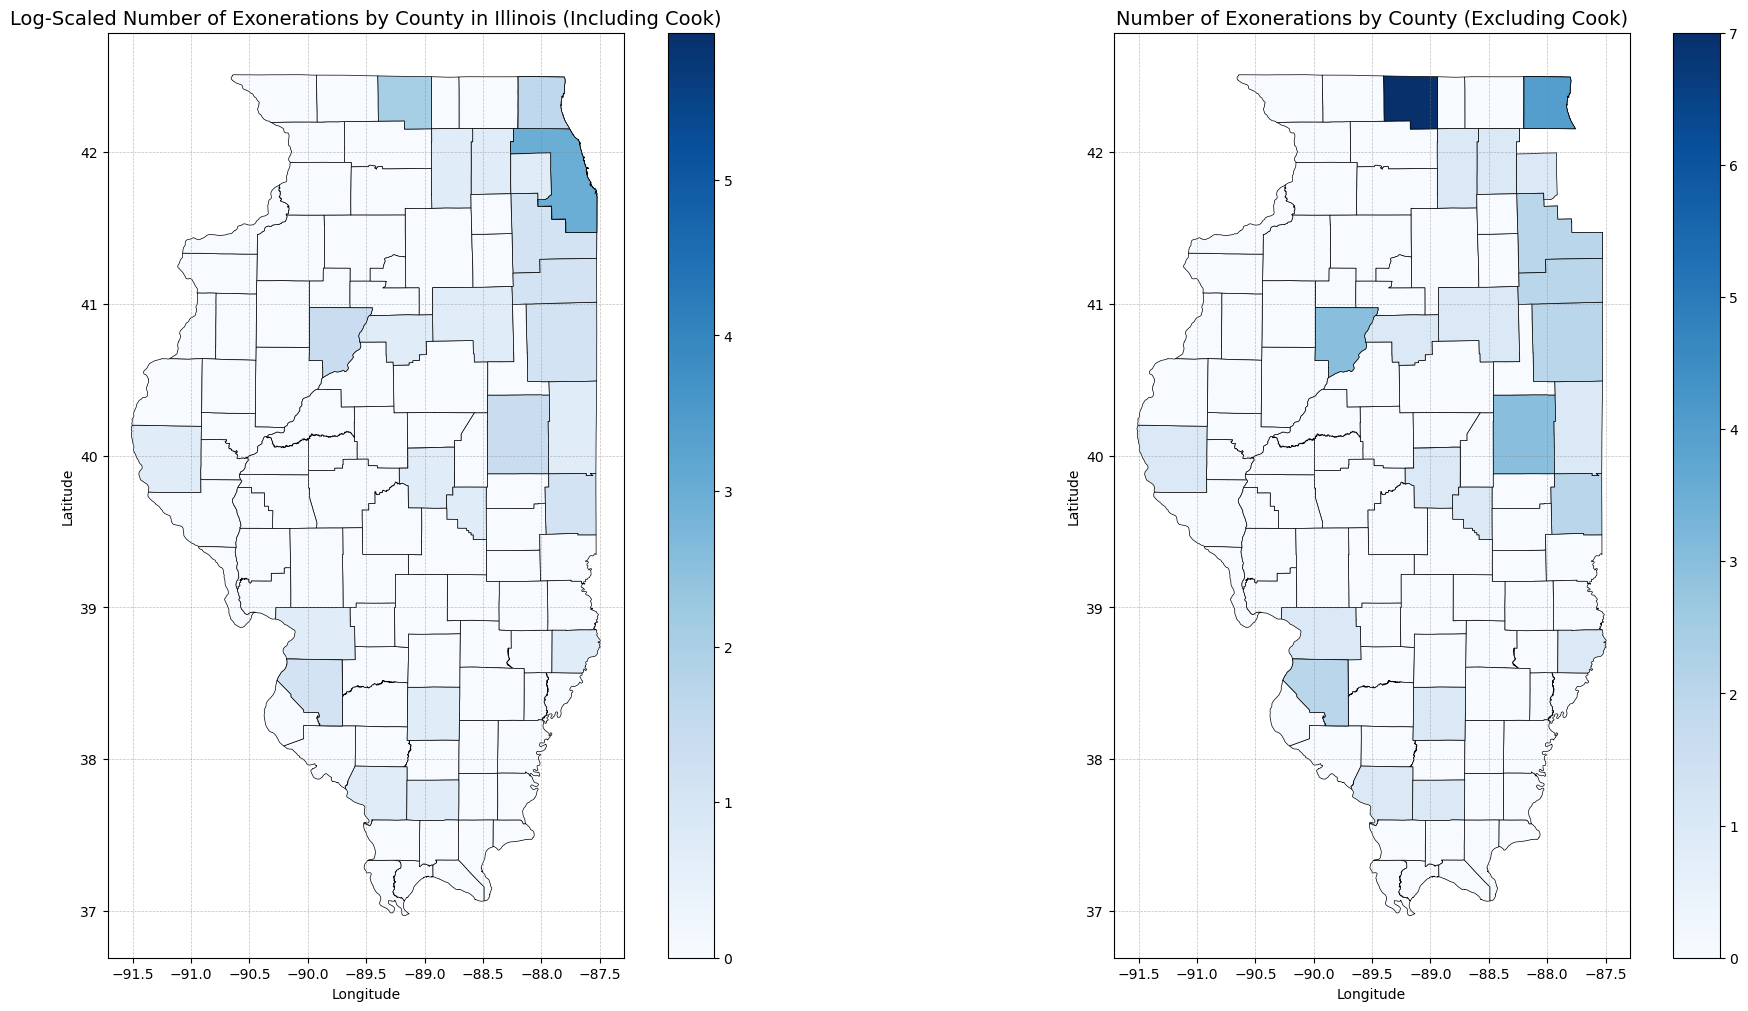

In [348]:
# Creates side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(20, 10), constrained_layout=True)

merged_counties.plot(
    column='log_num_exonerations',  # Use the log-transformed column
    cmap='Blues',
    linewidth=0.5,
    edgecolor='black',
    ax=axes[0],
    legend=True
)
axes[0].set_title("Log-Scaled Number of Exonerations by County in Illinois (Including Cook)", fontsize=14)
axes[0].set_xlabel("Longitude")
axes[0].set_ylabel("Latitude")
axes[0].grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# Plot the gradient map excluding Cook County, keeping linear scale
filtered_counties.plot(
    column='num_exonerations',  
    cmap='Blues',
    linewidth=0.5,
    edgecolor='black',
    ax=axes[1],
    legend=True
)
axes[1].set_title("Number of Exonerations by County (Excluding Cook)", fontsize=14)
axes[1].set_xlabel("Longitude")
axes[1].set_ylabel("Latitude")
axes[1].grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

plt.show()

The maps reveal critical patterns in both exonerations and arrests across Illinois counties. Cook County (Chicago), as expected, dominates the data with **orders of magnitude higher counts**, which skews the results and makes it challenging to identify trends in smaller counties. To address this, a **logarithmic transformation** (`np.log1p`) was applied to compress the data range, ensuring that smaller counties remain visible without flattening Cook County's impact.  

When Cook County is excluded, **linear scaling** highlights natural variations across the remaining counties. While smaller differences become more interpretable, the visualizations still emphasize the concentration of arrests and exonerations in urban regions outside Cook County. This dual scaling approach—logarithmic for overall visibility and linear for regional comparisons—strikes a balance, allowing geographic disparities across Illinois to emerge clearly.  

By visualizing both exonerations and arrests, the maps underscore systemic trends: wrongful convictions are disproportionately concentrated in high-population areas, particularly urban hubs. At the same time, significant activity persists in smaller counties, reinforcing the need for statewide examination of these issues.  

## Arrests by County

### Log-Scaled Total Arrests by County in Illinois 

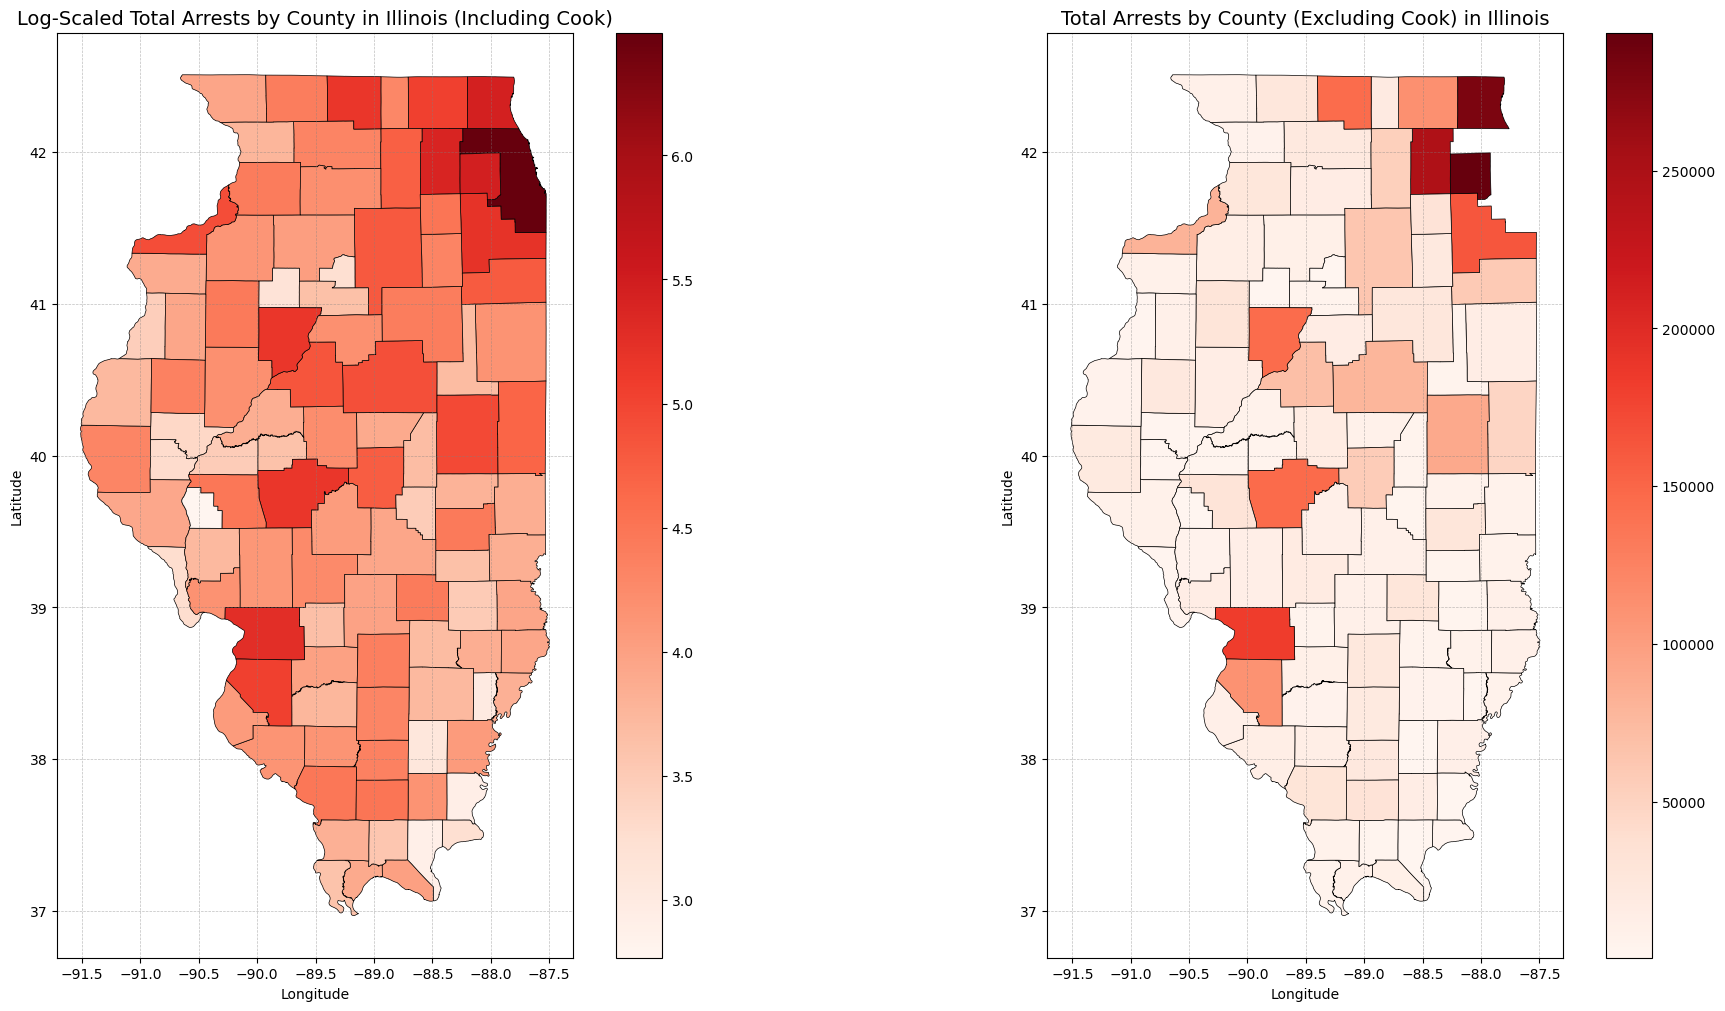

In [349]:
# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(20, 10), constrained_layout=True)

# Plot the gradient map for total arrests by county (including Cook County with log scale)
merged_total_arrests.plot(
    column='log_total_arrests',  # Use log-scaled data
    cmap='Reds',
    linewidth=0.5,
    edgecolor='black',
    ax=axes[0],
    legend=True
)
axes[0].set_title("Log-Scaled Total Arrests by County in Illinois (Including Cook)", fontsize=14)
axes[0].set_xlabel("Longitude")
axes[0].set_ylabel("Latitude")
axes[0].grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# Plot the gradient map for total arrests by county (excluding Cook County with linear scale)
filtered_total_arrests.plot(
    column='total_arrests',  # Use linear-scaled data
    cmap='Reds',
    linewidth=0.5,
    edgecolor='black',
    ax=axes[1],
    legend=True
)
axes[1].set_title("Total Arrests by County (Excluding Cook) in Illinois", fontsize=14)
axes[1].set_xlabel("Longitude")
axes[1].set_ylabel("Latitude")
axes[1].grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# Show the side-by-side maps
plt.show()

The maps highlight clear geographic disparities in arrest patterns across Illinois. Urban counties, particularly Cook County, dominate the arrest totals, even when using a logarithmic scale to compress the data. Cook County remains a significant outlier, with arrest counts orders of magnitude higher than in rural areas, driving the statewide totals.

When Cook County is excluded and linear scaling is applied, the smaller counties' arrest patterns become more visible. While some rural counties show modest variations, their arrest totals remain consistently lower than those in urban regions.

To provide further context, Illinois counties' rural and urban classifications **(see Appendix A)** align with these trends. Rural counties—defined by lower population densities—consistently exhibit fewer arrests, while urban counties, like Cook, DuPage, and Lake, demonstrate the systemic concentration of policing and arrests in high-population areas.

### Hypothesis Testing 

#### Mann-Whitney U Test
The Mann-Whitney U Test is a non-parametric statistical test used to compare whether two independent samples come from distributions with significantly different medians. Unlike parametric tests like the t-test, it does not assume normality, making it particularly useful for skewed data—like arrest counts, which often deviate from a normal distribution. This method is ideal for comparing Cook County (urban) to all other counties (primarily rural) to identify meaningful differences in arrest patterns. It is also robust to outliers, which are common in arrest data and can heavily skew the results of parametric tests.

The Mann-Whitney U test compares whether the distributions of **log-transformed arrests** differ significantly between Cook County and other counties.

- **Null Hypothesis (H₀):**  
  The distribution of **log-transformed total arrests** in Cook County is not significantly different from the distribution in other counties.  

- **Alternative Hypothesis (H₁):** The distribution of log-transformed total arrests in Cook County is significantly different from the distribution in other counties.  

In [356]:
from scipy.stats import mannwhitneyu

# Apply log scaling to total arrests
merged_total_arrests['log_total_arrests'] = np.log1p(merged_total_arrests['total_arrests'])

# Split data into Cook County and other counties using log-scaled arrests
cook_arrests = merged_total_arrests[merged_total_arrests['county'] == 'Cook']['log_total_arrests']
other_arrests = merged_total_arrests[merged_total_arrests['county'] != 'Cook']['log_total_arrests']

# Mann-Whitney U Test (non-parametric test)
u_stat, p_val = mannwhitneyu(cook_arrests, other_arrests, alternative='two-sided')
print(f"Mann-Whitney U Test (Log-Scaled): U-statistic = {u_stat:.4f}, p-value = {p_val:.4f}")

Mann-Whitney U Test (Log-Scaled): U-statistic = 101.0000, p-value = 0.0196


#### Hypotheses for Cohen's d (Effect Size)

Cohen's d quantifies the magnitude of the difference between the means of two groups, providing a standardized measure of effect size that allows for easy comparison. While the Mann-Whitney U Test determines whether there is a significant difference, Cohen's d measures the magnitude of that difference. A non-zero Cohen’s d indicates a meaningful difference in log-transformed total arrests between Cook County and other counties. By combining a statistical test (Mann-Whitney U) with an effect size (Cohen's d), we achieve a comprehensive understanding of both statistical significance and the practical importance of the observed differences.

- **Null Hypothesis (H₀):**  
  The effect size (Cohen's d) is close to zero, indicating no practical difference in the mean **log-transformed total arrests** between Cook County and other counties.

- **Alternative Hypothesis (H₁):**  
  The effect size (Cohen's d) is non-zero, suggesting a practical and meaningful difference in the mean **log-transformed total arrests** between Cook County and other counties.

In [357]:
# Debugging step: Print values
print("Mean (Cook arrests):", np.mean(cook_arrests))
print("Mean (Other arrests):", np.mean(other_arrests))
print("Standard Deviation (Cook arrests):", np.std(cook_arrests, ddof=1))
print("Standard Deviation (Other arrests):", np.std(other_arrests, ddof=1))

# Check for NaN or Inf in the data
print("Are there NaN values in Cook arrests?", np.isnan(cook_arrests).any())
print("Are there NaN values in Other arrests?", np.isnan(other_arrests).any())
print("Are there Inf values in Cook arrests?", np.isinf(cook_arrests).any())
print("Are there Inf values in Other arrests?", np.isinf(other_arrests).any())


Mean (Cook arrests): 14.953703751319162
Mean (Other arrests): 9.46284614509313
Standard Deviation (Cook arrests): nan
Standard Deviation (Other arrests): 1.3730102891385425
Are there NaN values in Cook arrests? False
Are there NaN values in Other arrests? False
Are there Inf values in Cook arrests? False
Are there Inf values in Other arrests? False


In [353]:
# Check for empty data or NaN values
if cook_arrests.empty or other_arrests.empty:
    print("One of the groups is empty. Cannot calculate Cohen's d.")
else:
    # Calculate mean and standard deviation
    mean_cook = np.mean(cook_arrests)
    mean_other = np.mean(other_arrests)
    std_cook = np.std(cook_arrests, ddof=1)
    std_other = np.std(other_arrests, ddof=1)

    # Check for zero variance
    if std_cook == 0 or std_other == 0:
        print("Standard deviation is zero in one of the groups. Cannot calculate Cohen's d.")
    else:
        # Pooled standard deviation
        std_pooled = np.sqrt(((len(cook_arrests) - 1) * std_cook**2 +
                             (len(other_arrests) - 1) * std_other**2) / 
                             (len(cook_arrests) + len(other_arrests) - 2))
        
        # Calculate Cohen's d
        cohens_d = (mean_cook - mean_other) / std_pooled
        print(f"Cohen's d (Effect Size, Log-Scaled): {cohens_d:.4f}")


Cohen's d (Effect Size, Log-Scaled): nan


## Total Arrests by Race and County
### Log-Scaled Total Arrests by Race and County

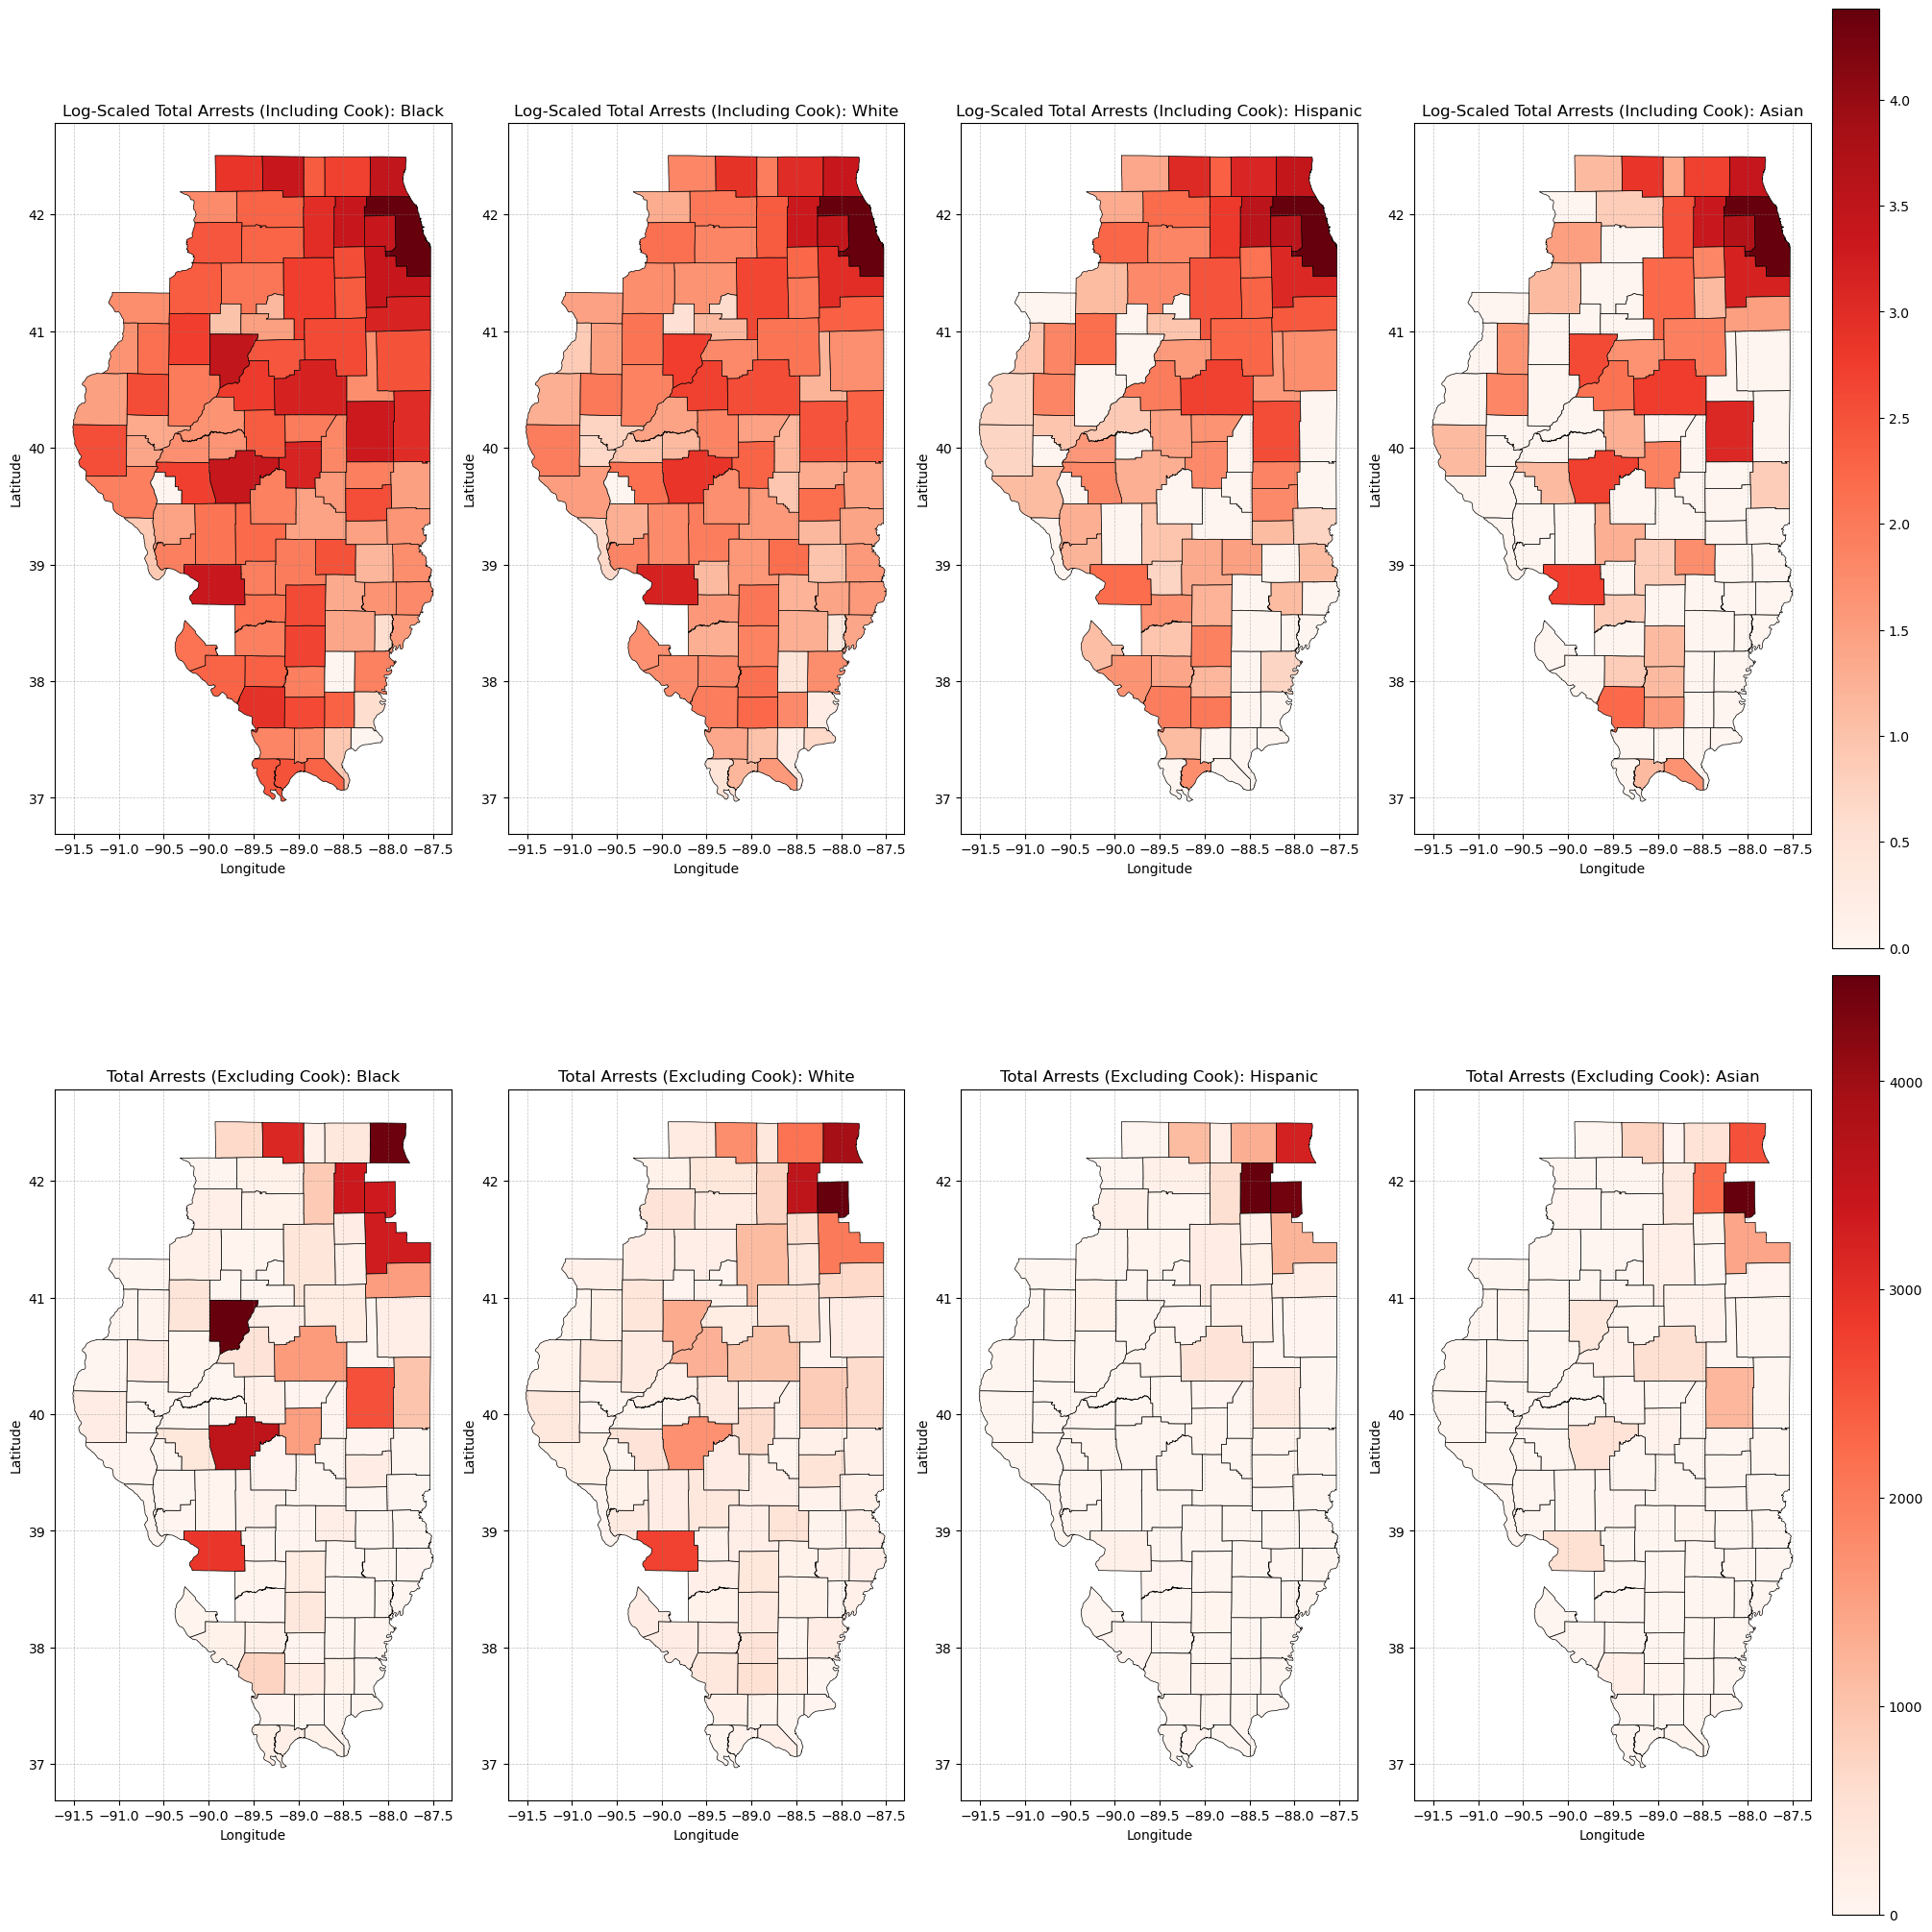

In [333]:
merged_total_arrests = illinois_counties.merge(
    aggregated_data_melted, on='county', how='left'
)

merged_total_arrests['total_arrests'] = merged_total_arrests['total_arrests'].fillna(0)

# Log-transform total arrests for maps including Cook County
merged_total_arrests['log_total_arrests'] = np.log10(merged_total_arrests['total_arrests'] + 1)  # Add 1 to avoid log(0)

# Filter out Cook County
merged_data_excluding_cook = merged_total_arrests[merged_total_arrests['county'] != 'Cook']

# Define the races to plot
races_to_plot = ["Black", "White", "Hispanic", "Asian"]

# Create subplots
fig, axes = plt.subplots(2, len(races_to_plot), figsize=(20, 20), constrained_layout=True)

# Plot each race's data (including Cook County with log scale) on the first row
for i, race in enumerate(races_to_plot):
    race_data = merged_total_arrests[merged_total_arrests['race'] == race]

    # Ensure data is not empty
    if race_data.empty:
        print(f"No data available for the selected race: {race}")
        continue

    # Plot the gradient map for the current race
    race_data.plot(
        column='log_total_arrests',  # Use log-transformed data
        cmap='Reds',
        linewidth=0.5,
        edgecolor='black',
        ax=axes[0, i],
        legend=(i == len(races_to_plot) - 1)  # Show legend only on the last subplot
    )
    axes[0, i].set_title(f"Log-Scaled Total Arrests (Including Cook): {race}")
    axes[0, i].set_xlabel("Longitude")
    axes[0, i].set_ylabel("Latitude")
    axes[0, i].grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# Plot each race's data (excluding Cook County with linear scale) on the second row
for i, race in enumerate(races_to_plot):
    race_data = merged_data_excluding_cook[merged_data_excluding_cook['race'] == race]

    # Ensure data is not empty
    if race_data.empty:
        print(f"No data available for the selected race: {race}")
        continue

    # Plot the gradient map for the current race
    race_data.plot(
        column='total_arrests',  # Use linear scale for excluding Cook
        cmap='Reds',
        linewidth=0.5,
        edgecolor='black',
        ax=axes[1, i],
        legend=(i == len(races_to_plot) - 1)  # Show legend only on the last subplot
    )
    axes[1, i].set_title(f"Total Arrests (Excluding Cook): {race}")
    axes[1, i].set_xlabel("Longitude")
    axes[1, i].set_ylabel("Latitude")
    axes[1, i].grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# Show the plot
plt.show()

### Hypothesis Testing 
#### Kruskal-Wallis

Null Hypothesis (H₀): There is no significant difference in total arrests across racial groups.
Alternative Hypothesis (H₁): There is a significant difference in total arrests across racial groups.


In [334]:
from scipy.stats import kruskal

# Group total arrests by race
black_arrests = merged_total_arrests[merged_total_arrests['race'] == 'Black']['total_arrests']
white_arrests = merged_total_arrests[merged_total_arrests['race'] == 'White']['total_arrests']
hispanic_arrests = merged_total_arrests[merged_total_arrests['race'] == 'Hispanic']['total_arrests']

# Kruskal-Wallis Test
h_stat, p_val = kruskal(black_arrests, white_arrests, hispanic_arrests)
print(f"Kruskal-Wallis Test: H-statistic = {h_stat:.4f}, p-value = {p_val:.4f}")


Kruskal-Wallis Test: H-statistic = 161.1528, p-value = 0.0000


#### Mann-Whitney U Test
Null Hypothesis (H₀): There is no significant difference in total arrests for a racial group between Cook County and other counties.
Alternative Hypothesis (H₁): There is a significant difference.

In [335]:
races = ['Black', 'White', 'Hispanic']
for race in races:
    cook_arrests = merged_total_arrests[
        (merged_total_arrests['county'] == 'Cook') & (merged_total_arrests['race'] == race)
    ]['total_arrests']
    other_arrests = merged_total_arrests[
        (merged_total_arrests['county'] != 'Cook') & (merged_total_arrests['race'] == race)
    ]['total_arrests']
    
    if len(cook_arrests) > 0 and len(other_arrests) > 0:
        u_stat, p_val = mannwhitneyu(cook_arrests, other_arrests, alternative='two-sided')
        print(f"{race} Arrests - Mann-Whitney U Test: U-statistic = {u_stat:.4f}, p-value = {p_val:.4f}")


Black Arrests - Mann-Whitney U Test: U-statistic = 98.0000, p-value = 0.0897
White Arrests - Mann-Whitney U Test: U-statistic = 98.0000, p-value = 0.0202
Hispanic Arrests - Mann-Whitney U Test: U-statistic = 98.0000, p-value = 0.0851


## Overrepresentation by County

### Log-Scaled Overrepresentation Ratios by County
The raw values for the **overrepresentation ratios** across races clearly demonstrate the need for scaling. Given the wide disparity in values, **log scaling** was implemented to compress large values while preserving their relative differences. To ensure consistency across maps, a **global color scale** was applied using `vmin` and `vmax`. This guarantees that the same color represents the same value across all maps, making comparisons more meaningful:

#### Raw Values for Overrepresentation Ratios

The raw values for the **overrepresentation ratios** across races clearly demonstrate the need for scaling:


In [336]:
demographic_df = pd.read_csv('../../data/processed-data/representation_by_county.csv')

# Merge demographic data with Illinois shapefile
merged_demographics = illinois_counties.merge(
    demographic_df, on='county', how='left'
)

# Define the ratios to plot
ratios_to_plot = [
    'ratio_of_overrepresentation_of_whites_incarcerated_compared_to_whites_non-incarcerated',
    'ratio_of_overrepresentation_of_blacks_incarcerated_compared_to_blacks_non-incarcerated',
    'ratio_of_overrepresentation_of_latinos_incarcerated_compared_to_latinos_non-incarcerated'
]

# Display min, mean, max, and std for each overrepresentation ratio
for ratio in ratios_to_plot:
    stats = merged_demographics[ratio].agg(['min', 'mean', 'max', 'std'])
    print(f"{ratio}:\n{stats}\n")

ratio_of_overrepresentation_of_whites_incarcerated_compared_to_whites_non-incarcerated:
min     0.000000
mean    0.517474
max     1.070000
std     0.319997
Name: ratio_of_overrepresentation_of_whites_incarcerated_compared_to_whites_non-incarcerated, dtype: float64

ratio_of_overrepresentation_of_blacks_incarcerated_compared_to_blacks_non-incarcerated:
min       0.000000
mean     40.916211
max     418.720000
std      78.475567
Name: ratio_of_overrepresentation_of_blacks_incarcerated_compared_to_blacks_non-incarcerated, dtype: float64

ratio_of_overrepresentation_of_latinos_incarcerated_compared_to_latinos_non-incarcerated:
min      0.000000
mean     6.393895
max     96.150000
std     12.830208
Name: ratio_of_overrepresentation_of_latinos_incarcerated_compared_to_latinos_non-incarcerated, dtype: float64



Evidently, the scales are wildly disproportionate:

- The mean for Blacks (~41) is orders of magnitude higher than for Whites (~0.5) or Latinos (~6).
- The standard deviation (std) further emphasizes the disparity, particularly for Black incarceration rates.

Even with log scaling, the imbalance remains striking but becomes much easier to visualize and compare.

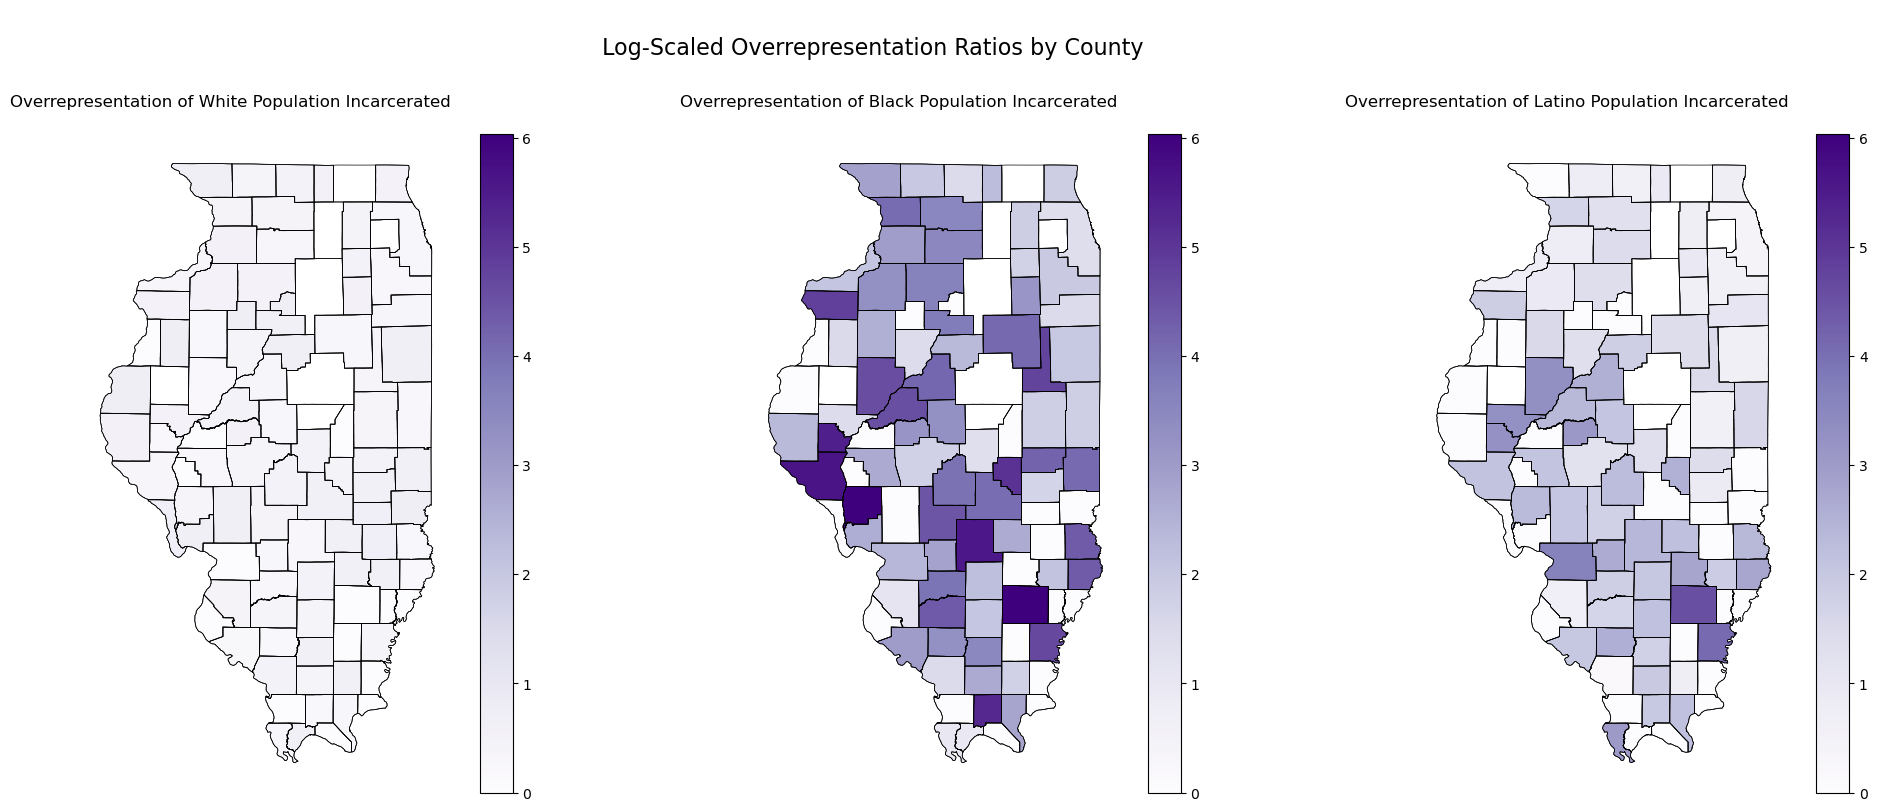

In [337]:
# Titles for the plots
titles = [
    "Overrepresentation of White Population Incarcerated",
    "Overrepresentation of Black Population Incarcerated",
    "Overrepresentation of Latino Population Incarcerated"
]

# Apply log scaling to ratios and store in new columns
for ratio in ratios_to_plot:
    merged_demographics[f'log_{ratio}'] = np.log1p(merged_demographics[ratio])  # log1p avoids log(0)

# Combine all log-scaled ratios to get global color scale
all_log_ratios = pd.concat([
    merged_demographics[f'log_{ratios_to_plot[0]}'],
    merged_demographics[f'log_{ratios_to_plot[1]}'],
    merged_demographics[f'log_{ratios_to_plot[2]}']
], axis=0)

# Get global color scale for log values
vmin, vmax = all_log_ratios.min(), all_log_ratios.max()

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 8), constrained_layout=True)

# Plot each log-scaled ratio
for i, ratio in enumerate(ratios_to_plot):
    # BASE LAYER: Plot county boundaries
    illinois_counties.boundary.plot(
        ax=axes[i],
        linewidth=0.5,
        color="black"
    )

    # OVERLAY: Plot the log-transformed ratio data
    merged_demographics.plot(
        column=f'log_{ratio}',
        cmap='Purples',
        linewidth=0.5,
        edgecolor='black',
        ax=axes[i],
        legend=True,
        vmin=vmin,  # Global log scale min
        vmax=vmax   # Global log scale max
    )
    
    # Centered titles
    axes[i].set_title(titles[i], fontsize=12, loc='center', pad=20, x=0.4)

    axes[i].set_axis_off()  # Hide axes for clean appearance

plt.suptitle("\n Log-Scaled Overrepresentation Ratios by County \n", fontsize=16)

plt.show()

### Hypothesis Testing
#### Kruskal-Wallis Test:

Null Hypothesis (H₀): The log-scaled ratios have no significant differences across the three racial groups.
If p-value < 0.05, reject H₀ and conclude there are differences.

In [338]:
#Kruskal - Wallis
# Extract log-scaled ratios for each group
white_ratios = merged_demographics[f'log_{ratios_to_plot[0]}'].dropna()
black_ratios = merged_demographics[f'log_{ratios_to_plot[1]}'].dropna()
latino_ratios = merged_demographics[f'log_{ratios_to_plot[2]}'].dropna()

# Kruskal-Wallis Test to check for overall differences
h_stat, p_val = kruskal(white_ratios, black_ratios, latino_ratios)
print(f"Kruskal-Wallis Test: H-statistic = {h_stat:.4f}, p-value = {p_val:.4f}")


Kruskal-Wallis Test: H-statistic = 62.1876, p-value = 0.0000


#### Pairwise Mann-Whitney U Tests:

Compares each pair (White vs. Black, White vs. Latino, Black vs. Latino) to pinpoint where the differences lie.
p-values < 0.05 indicate significant differences between the pair 


In [321]:
# Pairwise Mann-Whitney U Tests
if p_val < 0.05:  # Only run if Kruskal-Wallis indicates significance
    print("\nPerforming pairwise Mann-Whitney U Tests:")
    pairs = [('White', white_ratios), ('Black', black_ratios), ('Latino', latino_ratios)]
    
    for i in range(len(pairs)):
        for j in range(i + 1, len(pairs)):
            group1_name, group1 = pairs[i]
            group2_name, group2 = pairs[j]
            u_stat, p_val_pair = mannwhitneyu(group1, group2, alternative='two-sided')
            print(f"{group1_name} vs {group2_name}: U-statistic = {u_stat:.4f}, p-value = {p_val_pair:.4f}")


Performing pairwise Mann-Whitney U Tests:
White vs Black: U-statistic = 1848.0000, p-value = 0.0000
White vs Latino: U-statistic = 2591.5000, p-value = 0.0000
Black vs Latino: U-statistic = 6162.5000, p-value = 0.0000


# Disproportionality Analysis
The Disproportionality Index is calculated by dividing the proportion of exonerations for each race by the proportion of arrests for that race, as seen in proportionality and disparity analyses in social science and criminology research.
BASED OF CSH'S DISPARITY INDEX 
https://www.csh.org/csh-solutions/data/#RDDI 

https://www.csh.org/wp-content/uploads/2020/04/RDDI_OverviewHowTo.pdf

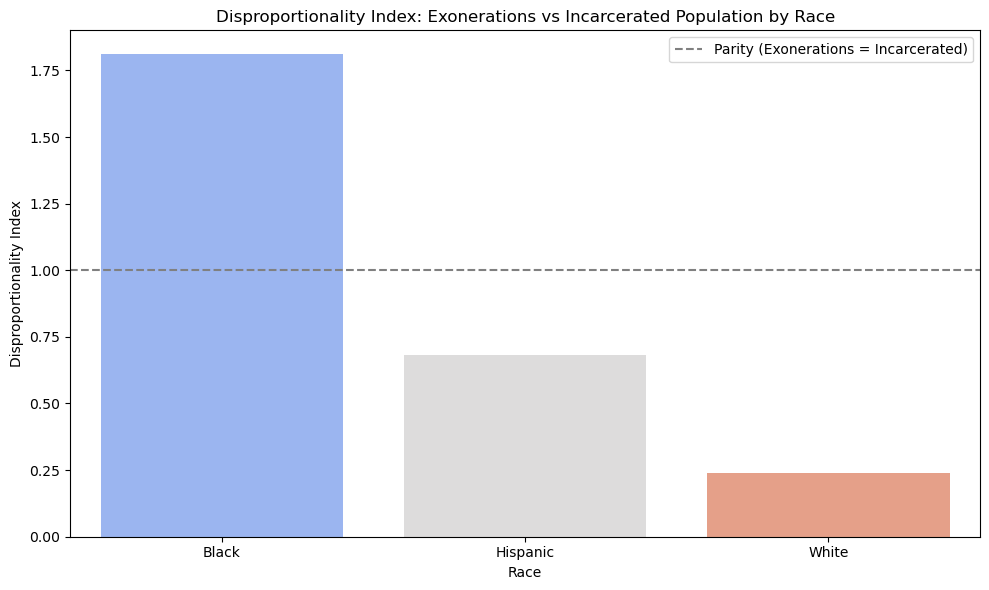

In [238]:
# Aggregate exoneration counts by race and county
exonerees_by_race_county = exon_df.groupby(['race', 'county']).size().reset_index(name='exonerees')

# Merge exonerations with demographic data on race and county
merged_exonerees_demo = exonerees_by_race_county.merge(
    merged_demographics, 
    on='county', 
    how='left'
)

# Filter only valid races present in the demographic data
valid_races = ['White', 'Black', 'Hispanic']  # Exclude Asian and Native American
merged_exonerees_demo = merged_exonerees_demo[merged_exonerees_demo['race'].isin(valid_races)]

# Aggregate incarcerated population by race
incarcerated_by_race = merged_exonerees_demo.groupby('race')[
    ['incarcerated_white_population', 'incarcerated_black_population', 'incarcerated_latino_population']
].sum()

# Map the columns to their respective race labels
incarcerated_by_race = incarcerated_by_race.rename(columns={
    'incarcerated_white_population': 'White',
    'incarcerated_black_population': 'Black',
    'incarcerated_latino_population': 'Hispanic'
})

# Sum incarcerated population for valid races only
incarcerated_total = incarcerated_by_race.sum(axis=1)

# Calculate total exonerations by race
exonerations_by_race = merged_exonerees_demo.groupby('race')['exonerees'].sum()

# Calculate percentages
incarcerated_percent = incarcerated_total / incarcerated_total.sum()
exoneration_percent = exonerations_by_race / exonerations_by_race.sum()

# Calculate disproportionality index
disproportionality_index = (exoneration_percent / incarcerated_percent).fillna(0)

# Convert to DataFrame for plotting
disproportionality_df = disproportionality_index.reset_index()
disproportionality_df.columns = ['race', 'disproportionality_index']

# Plot disproportionality index
plt.figure(figsize=(10, 6))
sns.barplot(data=disproportionality_df, x='race', y='disproportionality_index', palette='coolwarm')
plt.title("Disproportionality Index: Exonerations vs Incarcerated Population by Race")
plt.xlabel("Race")
plt.ylabel("Disproportionality Index")
plt.axhline(y=1, color='gray', linestyle='--', label="Parity (Exonerations = Incarcerated)")
plt.legend()
plt.tight_layout()
plt.show()



# Concept
Exonerations represent wrongful convictions that occurred as a result of arrests.
Arrests reflect the volume of individuals being taken into custody by law enforcement, which is a proxy for policing practices.
Disproportionality Index: Exonerations vs Arrests
If the ratio of exonerations to arrests is higher for a specific race, it suggests that individuals of that race are being wrongfully arrested and convicted at disproportionately high rates relative to their arrest volume.
This can indeed be interpreted as an indication of over-policing or bias in policing practices.


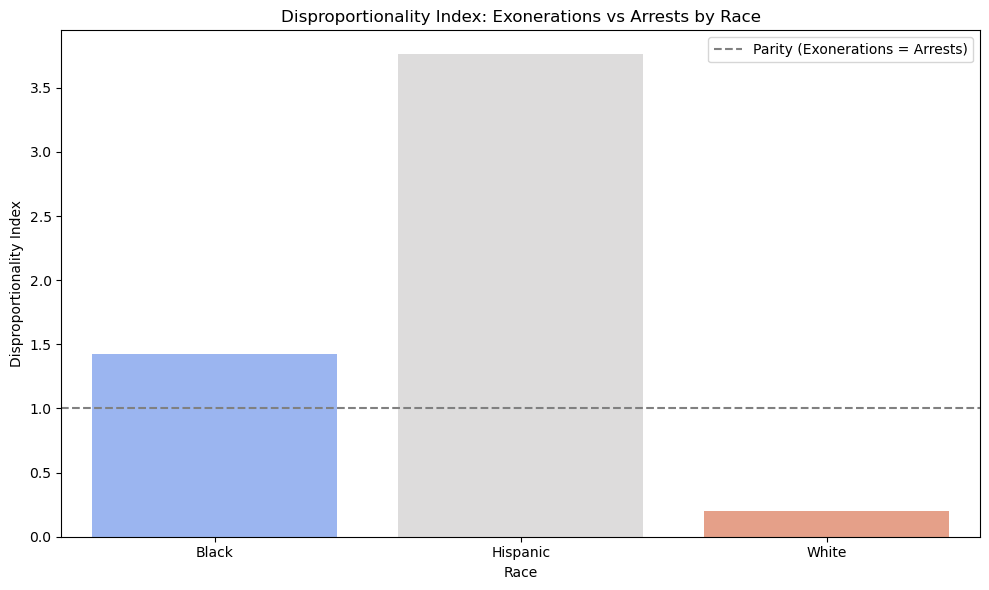

In [261]:
# Aggregate exoneration counts by race and county
exonerees_by_race_county = exon_df.groupby(['race', 'county']).size().reset_index(name='exonerees')
# Merge exonerees and arrests by race and county
merged_exoneree_arrest = exonerees_by_race_county.merge(
    aggregated_data_melted, on=['race', 'county'], how='left'
)

# Fill NaN values in arrests with 0 (in case no arrests are recorded for a county)
merged_exoneree_arrest['total_arrests'] = merged_exoneree_arrest['total_arrests'].fillna(0)

# Filter out races that are not relevant (Asian and Native American)
valid_races = ['White', 'Black', 'Hispanic']
merged_exoneree_arrest = merged_exoneree_arrest[merged_exoneree_arrest['race'].isin(valid_races)]

# Calculate total arrests and exonerations by race
total_arrests_by_race = merged_exoneree_arrest.groupby('race')['total_arrests'].sum()
total_exonerations_by_race = merged_exoneree_arrest.groupby('race')['exonerees'].sum()

# Calculate percentages
arrest_percent = total_arrests_by_race / total_arrests_by_race.sum() * 100
exoneration_percent = total_exonerations_by_race / total_exonerations_by_race.sum() * 100

# Calculate disproportionality index
disproportionality = (exoneration_percent / arrest_percent).fillna(0)

# Convert to DataFrame for plotting
disproportionality_df = disproportionality.reset_index()
disproportionality_df.columns = ['race', 'disproportionality_index']

# Plot disproportionality index
plt.figure(figsize=(10, 6))
sns.barplot(data=disproportionality_df, x='race', y='disproportionality_index', palette='coolwarm')
plt.title("Disproportionality Index: Exonerations vs Arrests by Race")
plt.xlabel("Race")
plt.ylabel("Disproportionality Index")
plt.axhline(1, color='gray', linestyle='--', label="Parity (Exonerations = Arrests)")
plt.legend()
plt.tight_layout()
plt.show()


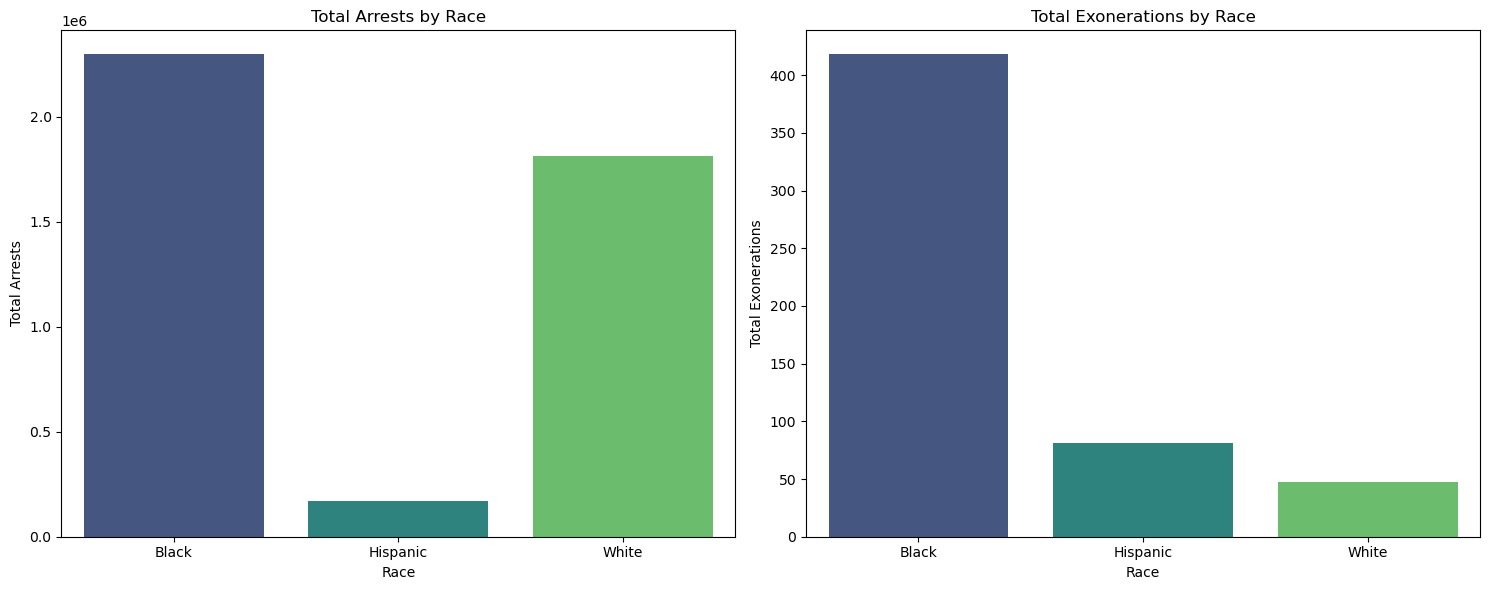

In [240]:
# Calculate raw counts for context
race_counts = merged_exoneree_arrest.groupby('race')[['exonerees', 'total_arrests']].sum().reset_index()

# Plot raw counts for comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot total arrests
sns.barplot(data=race_counts, x='race', y='total_arrests', ax=axes[0], palette='viridis')
axes[0].set_title("Total Arrests by Race")
axes[0].set_ylabel("Total Arrests")
axes[0].set_xlabel("Race")

# Plot total exonerations
sns.barplot(data=race_counts, x='race', y='exonerees', ax=axes[1], palette='viridis')
axes[1].set_title("Total Exonerations by Race")
axes[1].set_ylabel("Total Exonerations")
axes[1].set_xlabel("Race")

plt.tight_layout()
plt.show()


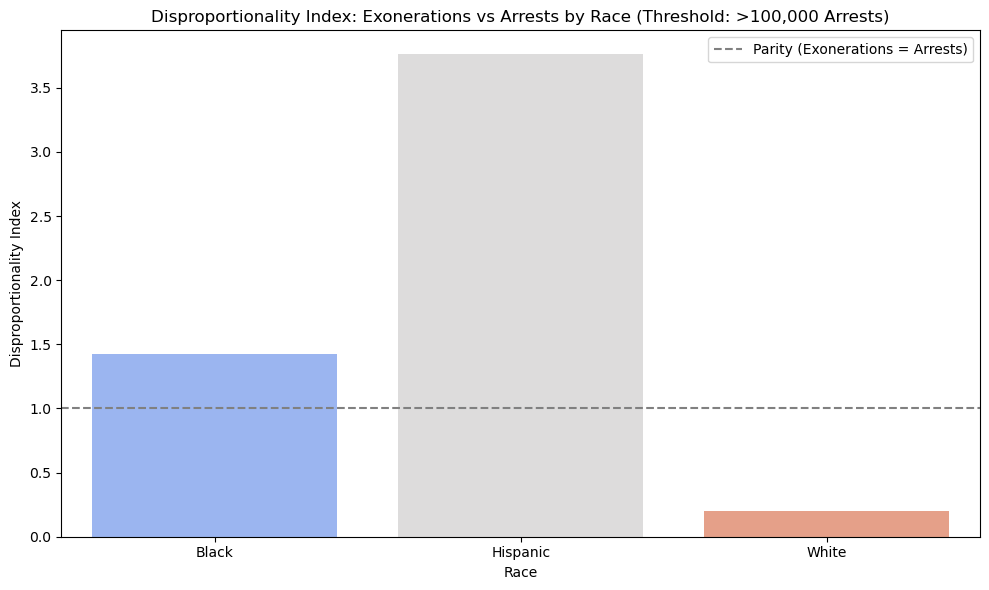

In [262]:
# Apply threshold: Only include races with total arrests > 100,000
total_arrests_by_race = total_arrests_by_race[total_arrests_by_race >168943]
valid_races_with_threshold = total_arrests_by_race.index  # Get the races that meet the threshold

# Filter exoneration counts to match the races above
total_exonerations_by_race = total_exonerations_by_race[total_exonerations_by_race.index.isin(valid_races_with_threshold)]

# Calculate percentages
arrest_percent = total_arrests_by_race / total_arrests_by_race.sum() * 100
exoneration_percent = total_exonerations_by_race / total_exonerations_by_race.sum() * 100

# Calculate disproportionality index
disproportionality = (exoneration_percent / arrest_percent).fillna(0)

# Convert to DataFrame for plotting
disproportionality_df = disproportionality.reset_index()
disproportionality_df.columns = ['race', 'disproportionality_index']

# Plot disproportionality index
plt.figure(figsize=(10, 6))
sns.barplot(data=disproportionality_df, x='race', y='disproportionality_index', palette='coolwarm')
plt.title("Disproportionality Index: Exonerations vs Arrests by Race (Threshold: >100,000 Arrests)")
plt.xlabel("Race")
plt.ylabel("Disproportionality Index")
plt.axhline(1, color='gray', linestyle='--', label="Parity (Exonerations = Arrests)")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Summarize counts by race
race_summary = merged_exoneree_arrest.groupby('race').agg(
    total_arrests=('total_arrests', 'sum'),
    total_exonerees=('exonerees', 'sum')
).reset_index()

pd.set_option('display.max_columns', None)  # Ensure all columns are visible
race_summary


,race,total_arrests,total_exonerees
0,Black,2297196.0,418
1,Hispanic,168944.0,81
2,White,1815269.0,47


In [108]:
total_arrests_sum = race_summary["total_arrests"].sum()
total_arrests_sum # Total arrests to determine an approrpraite threshold wel

4283841.0

In [110]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

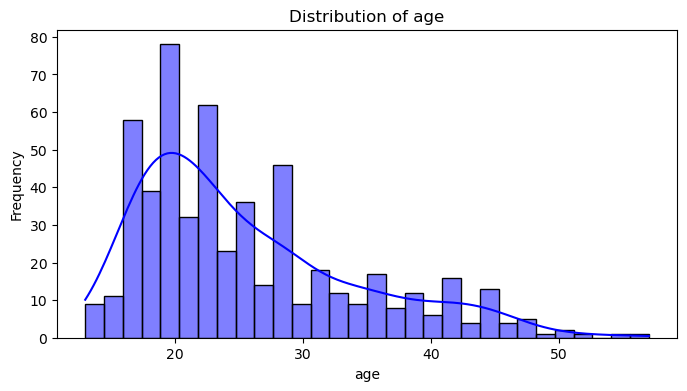

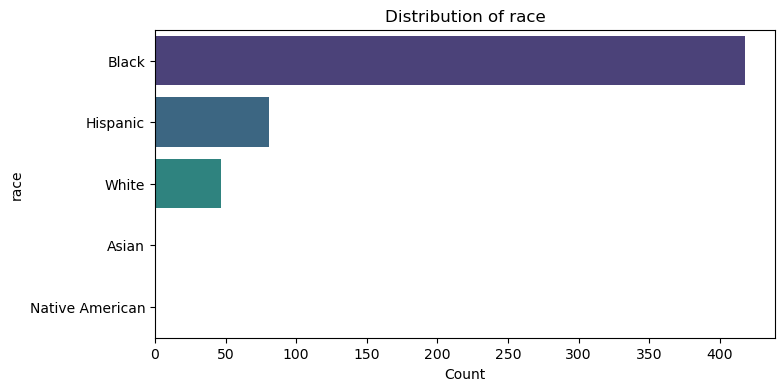

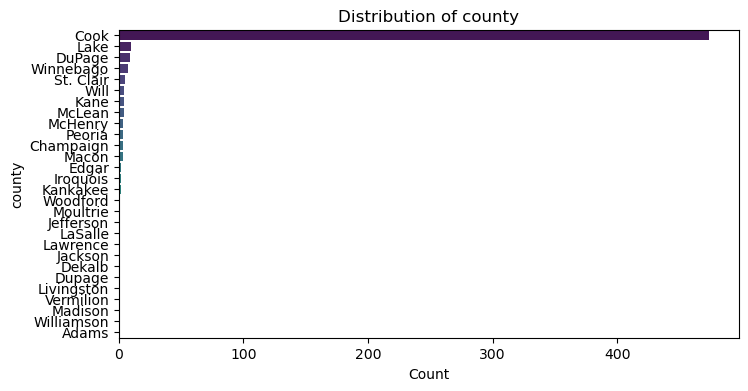

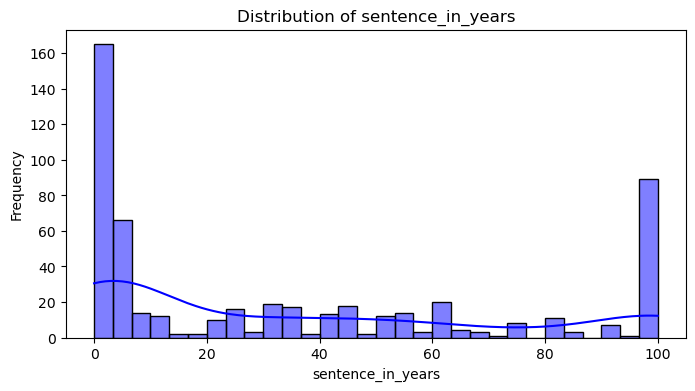

In [111]:
# Define the specific columns to visualize
columns_to_plot = ['age', 'race', 'county', 'sentence_in_years']

# Create histograms for the numeric or categorical distributions
for col in columns_to_plot:
    if col in exon_df.columns:  # Ensure the column exists
        plt.figure(figsize=(8, 4))
        
        # Check if the column is numeric or categorical
        if pd.api.types.is_numeric_dtype(df[col]):
            sns.histplot(df[col], kde=True, bins=30, color='blue')
            plt.title(f'Distribution of {col}')
            plt.xlabel(col)
            plt.ylabel('Frequency')
        else:
            sns.countplot(y=df[col], order=df[col].value_counts().index, palette='viridis')
            plt.title(f'Distribution of {col}')
            plt.xlabel('Count')
            plt.ylabel(col)
        
        plt.show()
    else:
        print(f"Column '{col}' does not exist in the dataset.")


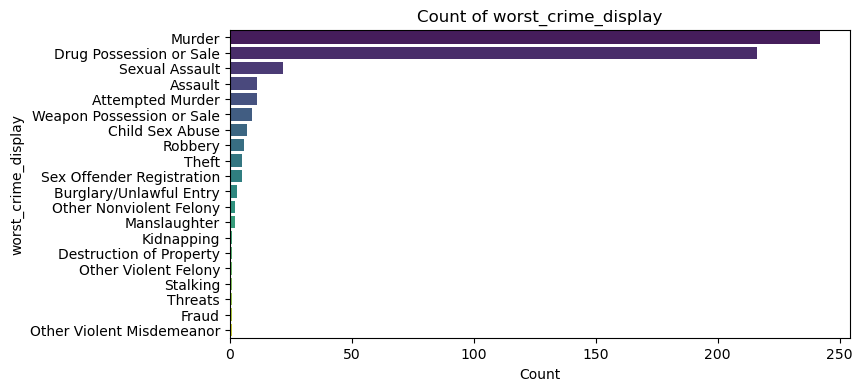

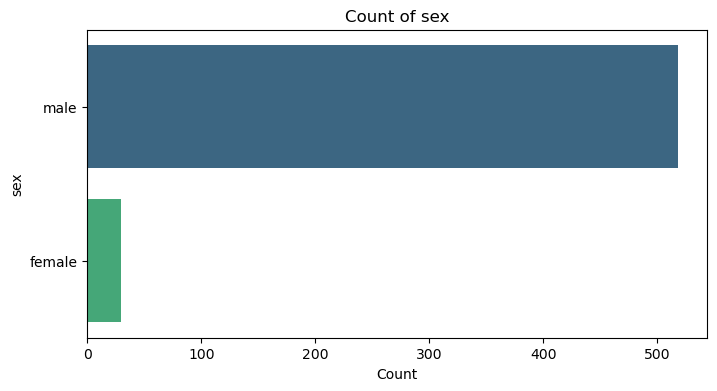

In [112]:
# Define the columns for counts
columns_to_count = ['worst_crime_display', 'sex']

# Generate count plots for these columns
for col in columns_to_count:
    if col in exon_df.columns:  # Ensure the column exists
        plt.figure(figsize=(8, 4))
        sns.countplot(y=df[col], order=df[col].value_counts().index, palette='viridis')
        plt.title(f'Count of {col}')
        plt.xlabel('Count')
        plt.ylabel(col)
        plt.show()
    else:
        print(f"Column '{col}' does not exist in the dataset.")

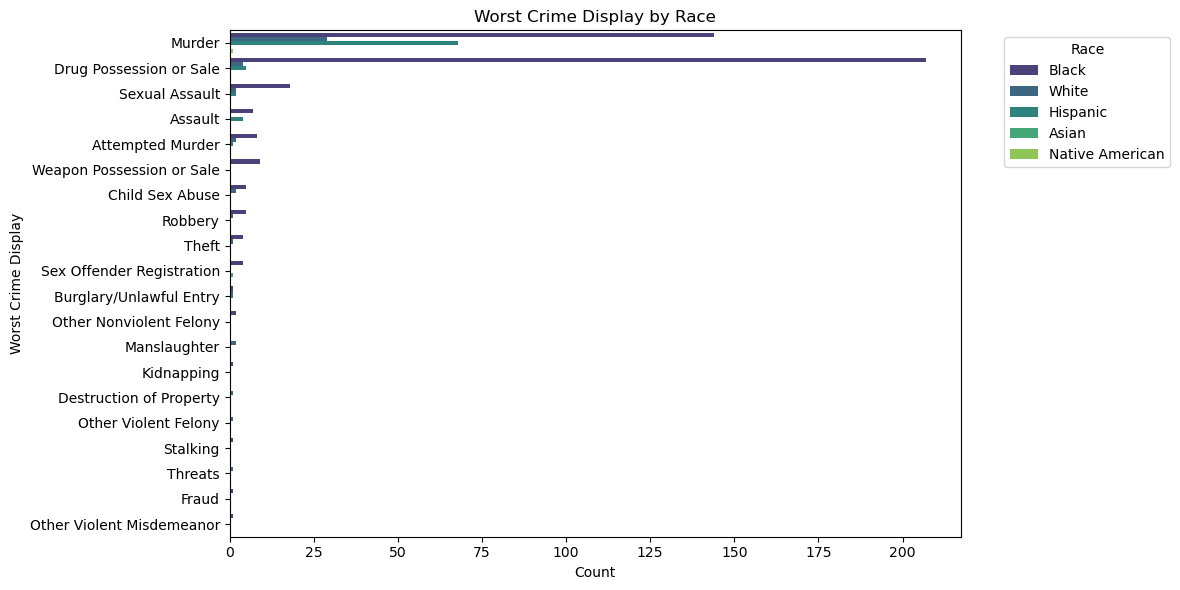

In [113]:
plt.figure(figsize=(12, 6))
sns.countplot(
    data=exon_df,
    y='worst_crime_display',
    hue='race',
    order=df['worst_crime_display'].value_counts().index,
    palette='viridis'
)
plt.title('Worst Crime Display by Race')
plt.xlabel('Count')
plt.ylabel('Worst Crime Display')
plt.legend(title='Race', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


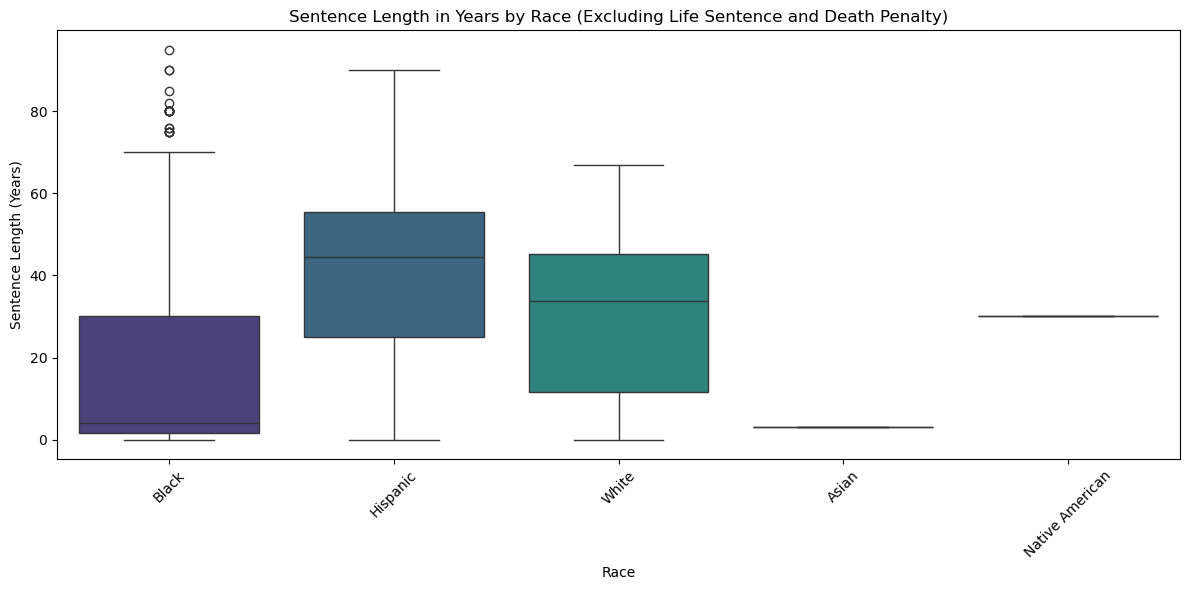

In [114]:
# Drop rows where sentence_in_years equals 100 -> life sentence and death penalty
df_filtered = exon_df[exon_df['sentence_in_years'] != 100]

# Plot Sentence in Years by Race
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_filtered, x='race', y='sentence_in_years', palette='viridis')
plt.title('Sentence Length in Years by Race (Excluding Life Sentence and Death Penalty)')
plt.xlabel('Race')
plt.ylabel('Sentence Length (Years)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\court\AppData\Local\Temp\ipykernel_38060\1186036694.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['normalized_sentence_length'] = (


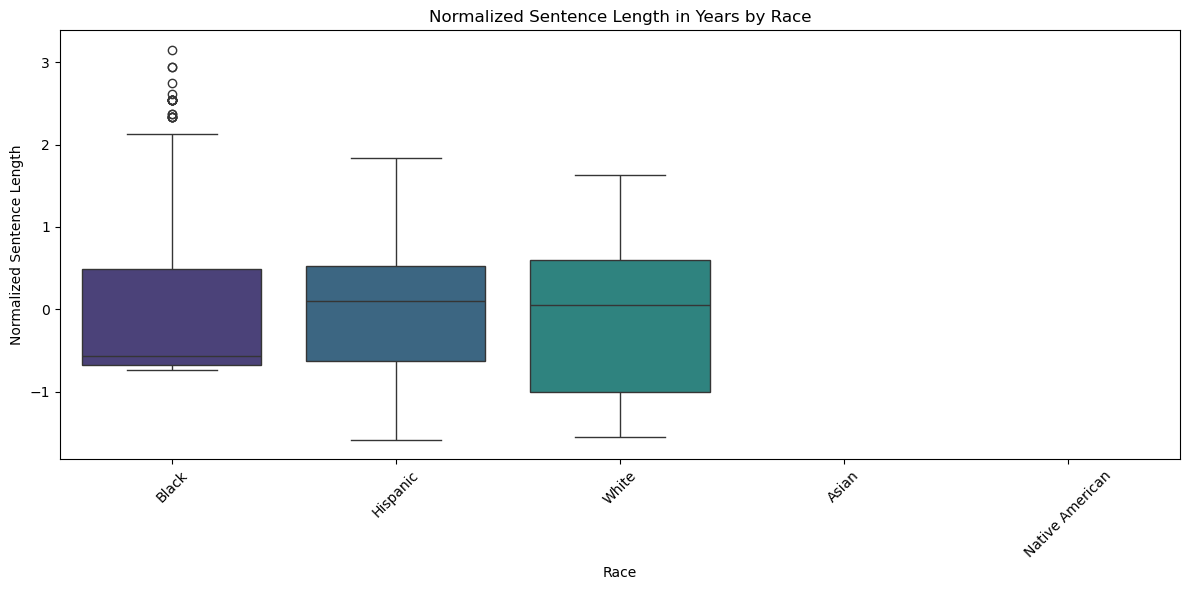

In [115]:
# Calculate sample size per race
race_counts = df_filtered['race'].value_counts()

#   Z-Score normalization
df_filtered['normalized_sentence_length'] = (
    df_filtered.groupby('race')['sentence_in_years']
    .transform(lambda x: (x - x.mean()) / x.std())
)

# Plot the normalized sentence lengths
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_filtered, x='race', y='normalized_sentence_length', palette='viridis')
plt.title('Normalized Sentence Length in Years by Race')
plt.xlabel('Race')
plt.ylabel('Normalized Sentence Length')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Misconduct EDA

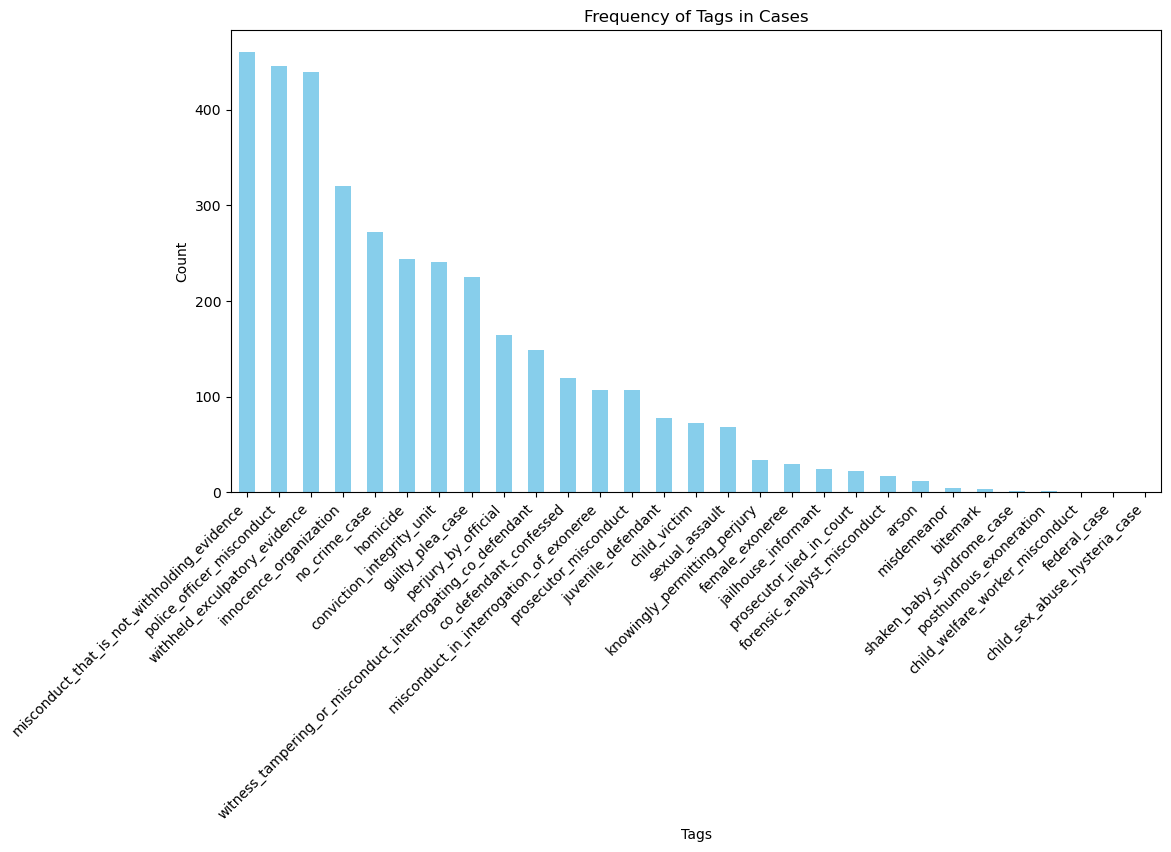

In [118]:
# Count the frequency of each tag
tag_columns = [
    'arson', 'bitemark', 'co_defendant_confessed', 'conviction_integrity_unit',
    'child_sex_abuse_hysteria_case', 'child_victim', 'female_exoneree', 
    'federal_case', 'homicide', 'innocence_organization', 'jailhouse_informant', 
    'juvenile_defendant', 'misdemeanor', 'no_crime_case', 'guilty_plea_case', 
    'posthumous_exoneration', 'sexual_assault', 'shaken_baby_syndrome_case',
    'prosecutor_misconduct', 'police_officer_misconduct', 'forensic_analyst_misconduct', 
    'child_welfare_worker_misconduct', 'withheld_exculpatory_evidence',
    'misconduct_that_is_not_withholding_evidence', 'knowingly_permitting_perjury', 
    'witness_tampering_or_misconduct_interrogating_co_defendant',
    'misconduct_in_interrogation_of_exoneree', 'perjury_by_official', 
    'prosecutor_lied_in_court'
]

# Count occurrences of each tag
tag_counts = exon_df[tag_columns].sum().sort_values(ascending=False)
tag_counts.plot(kind='bar', figsize=(12, 6), color='skyblue')
plt.title("Frequency of Tags in Cases")
plt.ylabel("Count")
plt.xlabel("Tags")
plt.xticks(rotation=45, ha='right')
plt.show()


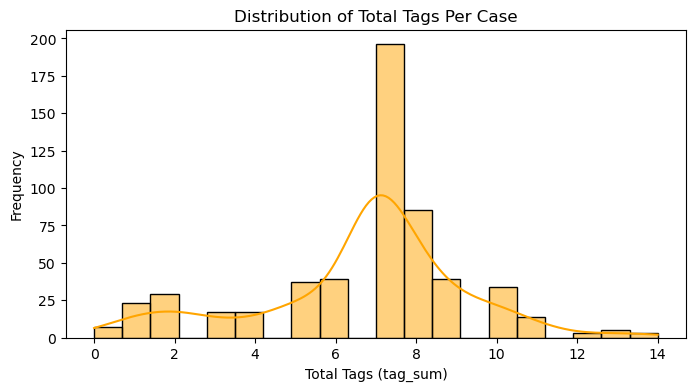

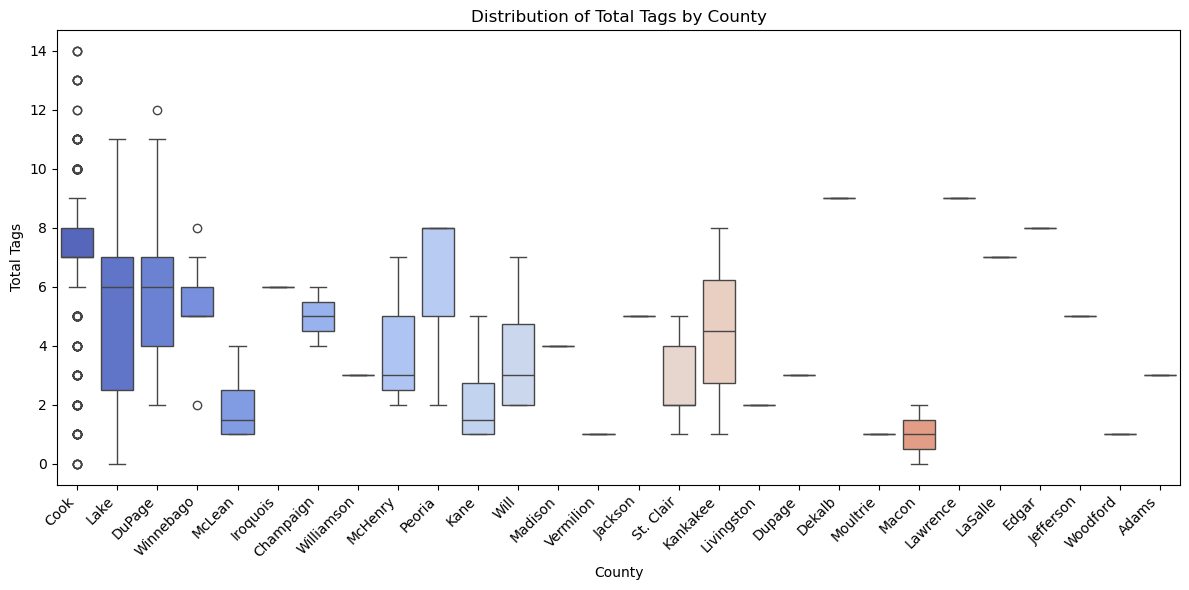

In [119]:
# Distribution of tag_sum
plt.figure(figsize=(8, 4))
sns.histplot(exon_df['tag_sum'], kde=True, bins=20, color='orange')
plt.title("Distribution of Total Tags Per Case")
plt.xlabel("Total Tags (tag_sum)")
plt.ylabel("Frequency")
plt.show()

# Tag sum by county
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='county', y='tag_sum', palette='coolwarm')
plt.title("Distribution of Total Tags by County")
plt.xlabel("County")
plt.ylabel("Total Tags")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


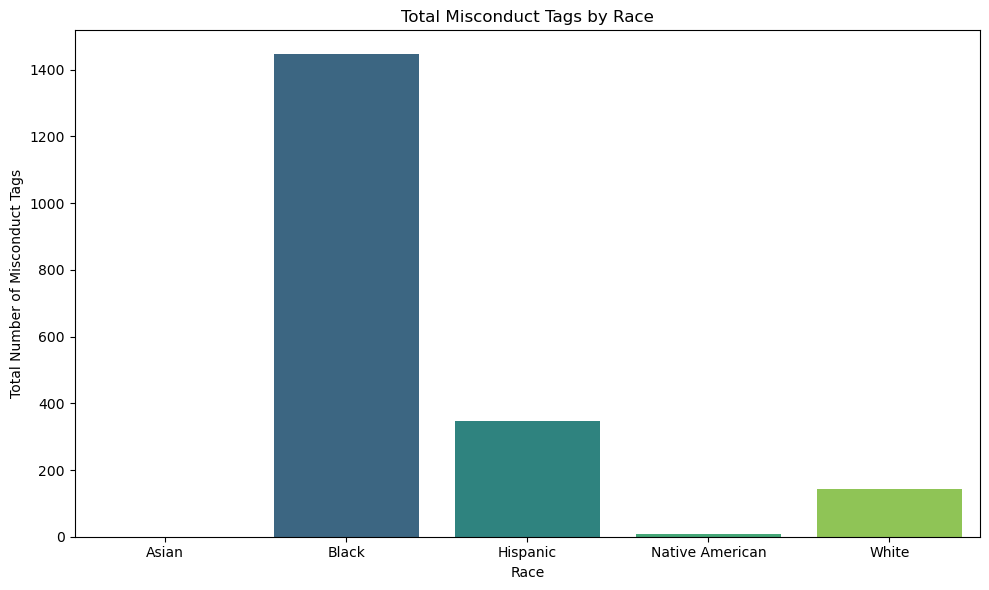

In [120]:
# Group misconduct-related tags
misconduct_tags = [
    'prosecutor_misconduct', 'police_officer_misconduct', 
    'forensic_analyst_misconduct', 'child_welfare_worker_misconduct',
    'withheld_exculpatory_evidence', 'misconduct_that_is_not_withholding_evidence',
    'knowingly_permitting_perjury', 'witness_tampering_or_misconduct_interrogating_co_defendant',
    'misconduct_in_interrogation_of_exoneree', 'perjury_by_official', 
    'prosecutor_lied_in_court'
]

# Create a column for combined misconduct
df['total_misconduct'] = exon_df[misconduct_tags].sum(axis=1)

# Aggregate total misconduct by race (using sum for total counts)
race_misconduct = df.groupby('race')['total_misconduct'].sum().reset_index()

# Bar plot of total misconduct by race
plt.figure(figsize=(10, 6))
sns.barplot(data=race_misconduct, x='race', y='total_misconduct', palette='viridis')
plt.title("Total Misconduct Tags by Race")
plt.xlabel("Race")
plt.ylabel("Total Number of Misconduct Tags")
plt.tight_layout()
plt.show()



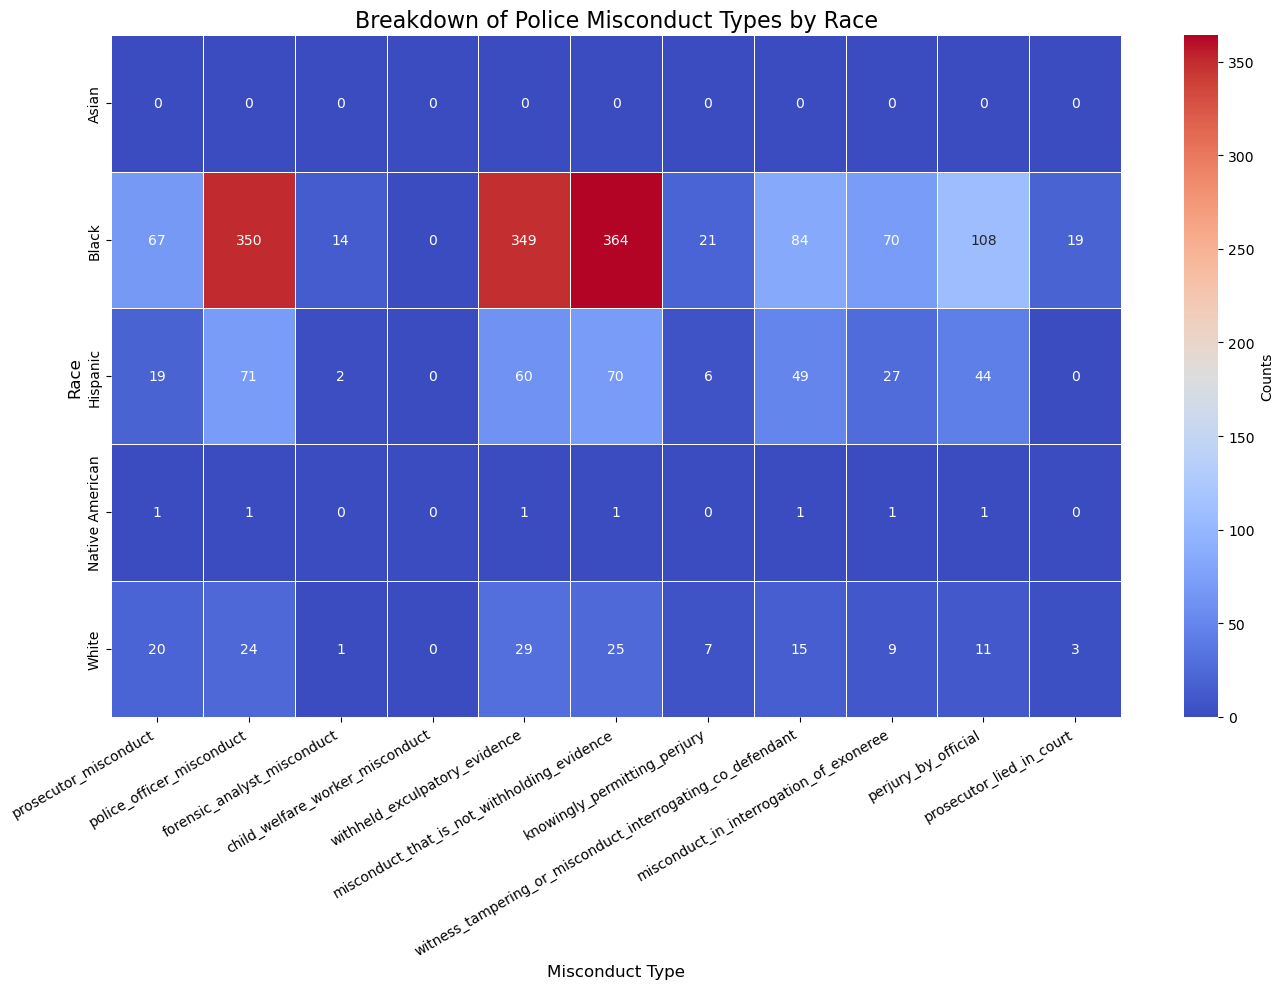

In [122]:
# Aggregate each misconduct tag by race
misconduct_by_race = exon_df.groupby('race')[misconduct_tags].sum()

# Heatmap of misconduct types by race with improved layout
plt.figure(figsize=(14, 10))  # Adjust figure size for better spacing
sns.heatmap(
    misconduct_by_race, 
    annot=True, 
    cmap='coolwarm', 
    fmt='d', 
    linewidths=0.5, 
    cbar_kws={'label': 'Counts'},  # Add a color bar label
    xticklabels=True, 
    yticklabels=True
)
plt.title("Breakdown of Police Misconduct Types by Race", fontsize=16)  # Larger title font size
plt.xlabel("Misconduct Type", fontsize=12)  # Larger x-axis label font size
plt.ylabel("Race", fontsize=12)  # Larger y-axis label font size
plt.xticks(rotation=30, ha='right', fontsize=10)  # Rotate x-axis labels for readability
plt.yticks(fontsize=10)  # Adjust y-axis label font size
plt.tight_layout()  # Optimize layout to avoid overlap
plt.show()

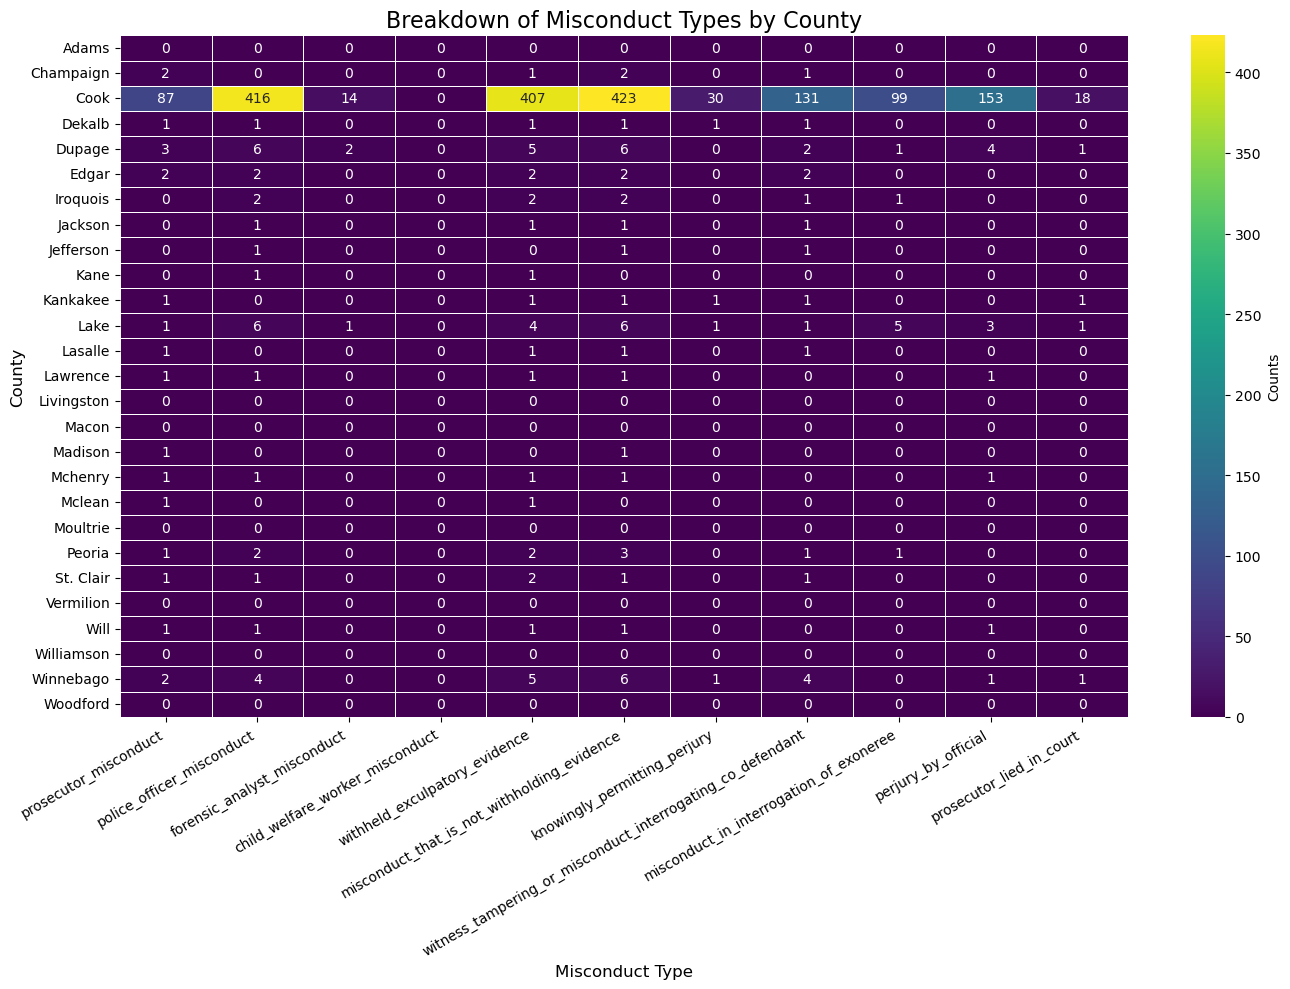

In [25]:
# Aggregate misconduct by county and type
misconduct_county = df.groupby('county')[misconduct_tags].sum()

# Heatmap of misconduct types by county
plt.figure(figsize=(14, 10))
sns.heatmap(
    misconduct_county,
    annot=True,
    cmap='viridis',
    fmt='.0f',  # Format numbers as integers
    linewidths=0.5,
    cbar_kws={'label': 'Counts'}
)
plt.title("Breakdown of Misconduct Types by County", fontsize=16)
plt.xlabel("Misconduct Type", fontsize=12)
plt.ylabel("County", fontsize=12)
plt.xticks(rotation=30, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


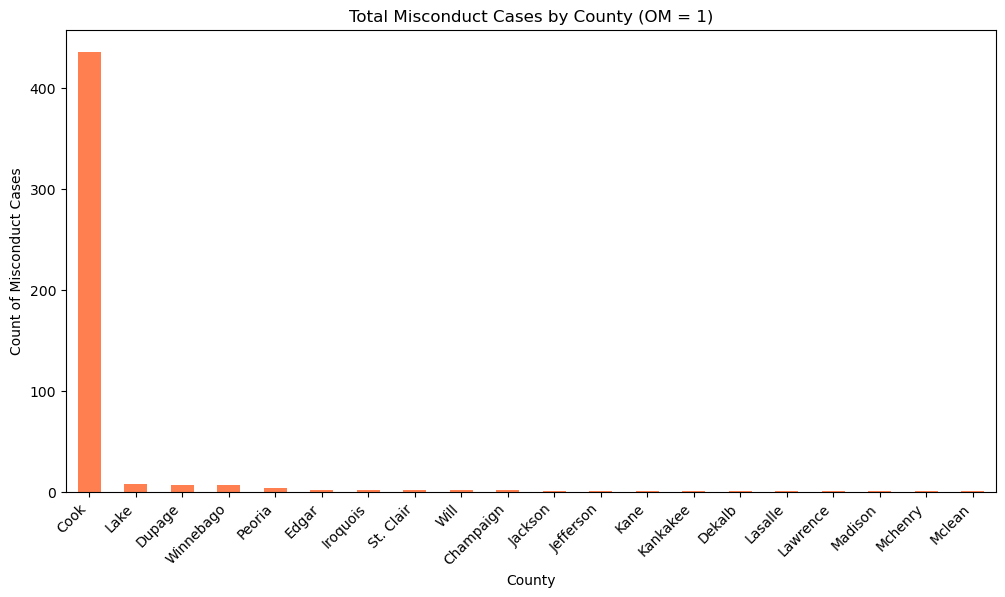

In [26]:
# Filter rows where OM equals 1
df_misconduct = df[df['om'] == 1]

# Misconduct counts by county
county_misconduct = df_misconduct.groupby('county').size().sort_values(ascending=False)

# Bar plot for misconduct by county
county_misconduct.plot(kind='bar', figsize=(12, 6), color='coral')
plt.title("Total Misconduct Cases by County (OM = 1)")
plt.xlabel("County")
plt.ylabel("Count of Misconduct Cases")
plt.xticks(rotation=45, ha='right')
plt.show()


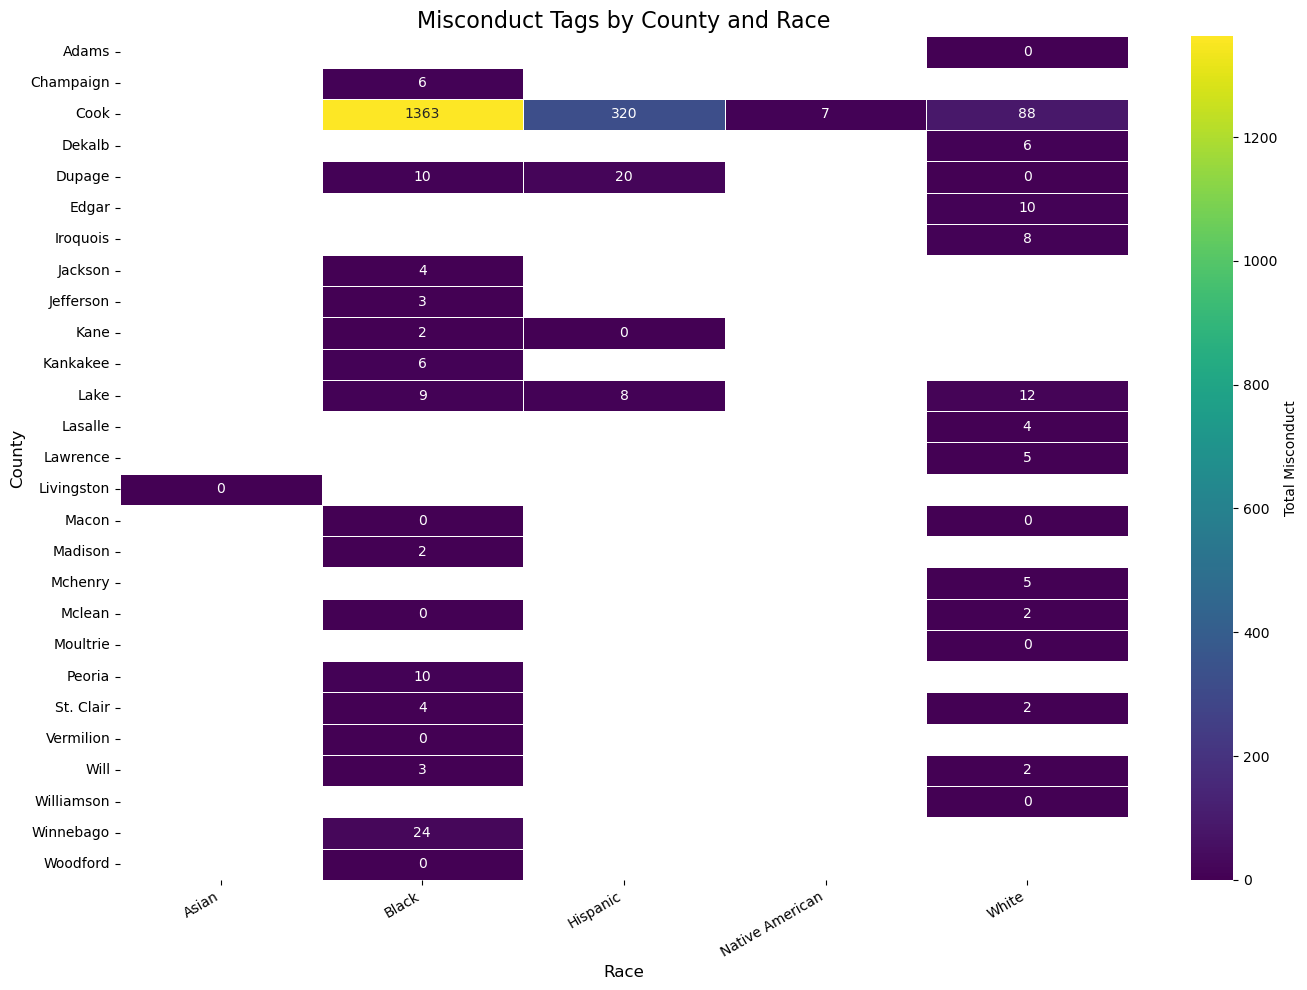

In [27]:
# Aggregate misconduct by county and race
misconduct_race_county = df.groupby(['county', 'race'])['total_misconduct'].sum().unstack()

# Heatmap of misconduct by county and race
plt.figure(figsize=(14, 10))
sns.heatmap(
    misconduct_race_county,
    annot=True,  # Add cell annotations
    cmap='viridis', 
    fmt='.0f',  # Format annotations as integers
    linewidths=0.5,  # Add gridlines
    cbar_kws={'label': 'Total Misconduct'}
)
plt.title("Misconduct Tags by County and Race", fontsize=16)
plt.xlabel("Race", fontsize=12)
plt.ylabel("County", fontsize=12)
plt.xticks(rotation=30, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()  # Adjust layout for readability
plt.show()
